# Table of Contents
* [Load Packages and Data](#Load-Packages-and-Data)
* [Topic Modeling](#Topic-Modeling) 
    * [Build LDA Model with sklearn](#Build-LDA-Model-with-sklearn)
        * [Clean-up Review Text](#Clean-up-Review-Text)
        * [Create the Document-Word Matrix](#Create-the-Document-Word-Matrix)
        * [LDA Model](#LDA-Model)
        * [Dominant Topic in each Document](#Dominant-Topic-in-each-Document)
        * [Visualize the LDA Model with pyLDAvis](#Visualize-the-LDA-Model-with-pyLDAvis)        
    * [Build LDA Model with Gensim](#Build-LDA-Model-with-Gensim)
        * [Create the Dictionary and Corpus Needed for Topic Modeling](#Create-the-Dictionary-and-Corpus-Needed-for-Topic-Modeling)
        * [Model Perplexity](#Model-Perplexity)
        * [Visualize Topics with pyLDAvis](#Visualize-Topics-with-pyLDAvis)
        * [Test on Holdout data](#Test-on-Holdout-data)
* [Build Machine Learning Models for Prediction](#Build-Machine-Learning-Models-for-Prediction)
    * [Create a Target Column](#Create-a-Target-Column)
        * [t-test of the Character Length of Reviews](#t-test-of-the-Character-Length-of-Reviews)
    * [Build a Pipeline](#Build-a-Pipeline)       
    * [Use bag-of-word Features for Prediction](#Use-bag-of-word-Features-for-Prediction)
        * [Dummy Classifiers](#Dummy-Classifier)
        * [NaiveBayes Classifier](#NaiveBayes-Classifier)
    * [Use Tfidf-weighted Features for Prediction](#Use-Tfidf-weighted-Features-for-Prediction)
        * [Feed Less TfidfVectorized Features to Classifier](#Feed-Less-TfidfVectorized-Features-to-Classifier)
    * [Use sklearn LDA Document Topics for Prediction](#Use-sklearn-LDA-Document-Topics-for-Prediction)
    * [Use Gensim LDA Document Topics for Prediction](#Use-Gensim-LDA-Document-Topics-for-Prediction)
    * [Compare Model Performance](#Compare-Model-Performance)
        * [Pick Classifiers](#Pick-Classifiers)
        * [Grid Search Hyperparameters](Grid-Search-Hyperparameters)
    * [Enrich Predictors with Categorical and Numerical Features](#Enrich-Predictors-with-Categorical-and-Numerical-Features)
        * [Save the Model](#Save-the-Model)

# Load Packages and Data 
This is the second part of the capstone project that investigates reviews dataset of hotels. It focuses on wrangling the text data and uses word features to train a machine learning classifier for hotel classification based on the review texts. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

#manipulate and view data in tabular format
import pandas as pd
import numpy as np
import pickle 
#process text
import re,nltk,spacy,gensim
from gensim.models import CoherenceModel
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

 #visualization tools
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 8

#seaborn
import seaborn as sns
sns.set(context='paper',style='whitegrid',font_scale=2, rc={"lines.linewidth": 2.5})#style=whitegrid,darkgrid,white,dark
pd.set_option('display.max_columns', None)


#LDA visualzation
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim




#sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn.preprocessing import FunctionTransformer, LabelBinarizer, Imputer, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix,roc_curve, auc, precision_recall_curve,average_precision_score


from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import cross_val_score,  KFold 

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint #Data pretty printer
from sklearn.feature_selection import SelectKBest,chi2




Using TensorFlow backend.
/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/phyhouhou/anaconda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We've cleaned the raw hotel data as reported in the [milestone report](https://github.com/phyhouhou/SpringboardProjects/blob/master/SecondCapstoneProject/2ndCapstoneProject_MilestoneReport/2ndCapstoneProject_Milestone.ipynb) by handling missing values, drop duplilcates and cleaning and enriching features. Here we load the cleaned hotel data for analysis and focus on the review texts.

In [2]:
data=pd.read_csv('data/htl_clean.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515212 entries, 0 to 515211
Data columns (total 24 columns):
Review_Date                                   515212 non-null object
Review_Month                                  515212 non-null object
Review_Wday                                   515212 non-null object
Hotel_Name                                    515212 non-null object
Hotel_Address                                 515212 non-null object
Hotel_City                                    515212 non-null object
lat                                           511944 non-null float64
lng                                           511944 non-null float64
Average_Score                                 515212 non-null float64
Total_Number_of_Reviews                       515212 non-null int64
Reviewer_Nationality                          515212 non-null object
Total_Number_of_Reviews_Reviewer_Has_Given    515212 non-null int64
Reviewer_Score                                515212 non-nul

,Review_Date,Review_Month,Review_Wday,Hotel_Name,Hotel_Address,Hotel_City,lat,lng,Average_Score,Total_Number_of_Reviews,Reviewer_Nationality,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Negative_Review,Review_Total_Negative_Word_Counts,Neg_Rev_WCRatio,Positive_Review,Review_Total_Positive_Word_Counts,Pos_Rev_WCRatio,Trip_Type,Traveler_Type,Num_Nights,Additional_Number_of_Scoring,days_since_review
0,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Russia,7,2.9,I am so angry that i made this post available...,397,0.973039,Only the park outside of the hotel was beauti...,11,0.026961,Leisure trip,Couple,6.0,194,0
1,2017-08-03,Aug,Thu,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Ireland,7,7.5,No Negative,0,0.000000,No real complaints the hotel was great great ...,105,1.000000,Leisure trip,Couple,4.0,194,0
2,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,Australia,9,7.1,Rooms are nice but for elderly a bit difficul...,42,0.666667,Location was good and staff were ok It is cut...,21,0.333333,Leisure trip,Family with young children,3.0,194,3
3,2017-07-31,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,United Kingdom,1,3.8,My room was dirty and I was afraid to walk ba...,210,0.889831,Great location in nice surroundings the bar a...,26,0.110169,Leisure trip,Solo traveler,3.0,194,3
4,2017-07-24,Jul,Mon,Hotel Arena,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,Amsterdam,52.360576,4.915968,7.7,1403,New Zealand,3,6.7,You When I booked with your company on line y...,140,0.945946,Amazing location and building Romantic setting,8,0.054054,Leisure trip,Couple,2.0,194,10


# Topic Modeling 

## Build LDA Model with sklearn
The aim  of topic modeling is to extract hidden topics from a large volume of texts and LDA is a popular algorithm for topic modeling. In this section, we will first clean the texts and then create a word-document matrix, which is a required input for implementing the LDA algorithm with sklearn. We will then build a LDA model and discuss the model performance to find out what topics reviewers are talking about. 

### Clean-up Review Text 

Review texts will be processed in the following steps:

* Remove short reviews
* Remove all non-letters characters;
* Strip whitespaces;
* Tokenize sentence into a list of words;
* Remove English stopwords;
* Lemmatize words to its roots.

Then we will save the cleaned review texts in a csv file for future analysis.

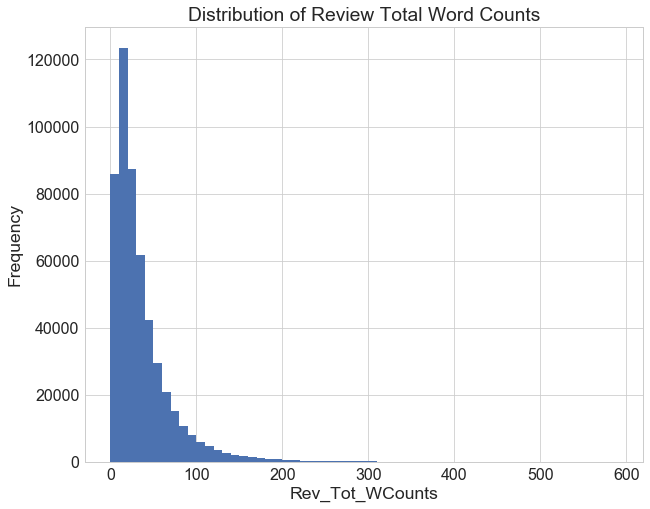

In [3]:
Rev_Tot_WCounts=data['Review_Total_Positive_Word_Counts']+data['Review_Total_Negative_Word_Counts']

plt.hist(Rev_Tot_WCounts,bins=np.arange(0,600,10))
plt.xlabel('Rev_Tot_WCounts')
plt.ylabel('Frequency')
plt.title('Distribution of Review Total Word Counts');



In [4]:
# Set for the total word count of a review a threshold below which reviews will be removed 
thresh=10
idx=Rev_Tot_WCounts<thresh
#len(data[idx])/len(data), len(data[~idx])


# Reorganize columns
categories=['Review_Month','Hotel_City','Reviewer_Nationality','Trip_Type','Traveler_Type']
numerics=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts',
          'Review_Total_Negative_Word_Counts','Num_Nights']
text=['Negative_Review','Positive_Review']
cols=categories+text+['Reviewer_Score']
df=data[~idx][cols]


df.Negative_Review.replace('No Negative', ' ',inplace=True)
df.Positive_Review.replace('No Positive', ' ',inplace=True)

# Combine positive and negative reviews
Full_Review=df.Negative_Review+' '+df.Positive_Review
for num,message in enumerate(Full_Review.head(10)):
    print(num,message)
    print ('\n')


0  I am so angry that i made this post available via all possible sites i use when planing my trips so no one will make the mistake of booking this place I made my booking via booking com We stayed for 6 nights in this hotel from 11 to 17 July Upon arrival we were placed in a small room on the 2nd floor of the hotel It turned out that this was not the room we booked I had specially reserved the 2 level duplex room so that we would have a big windows and high ceilings The room itself was ok if you don t mind the broken window that can not be closed hello rain and a mini fridge that contained some sort of a bio weapon at least i guessed so by the smell of it I intimately asked to change the room and after explaining 2 times that i booked a duplex btw it costs the same as a simple double but got way more volume due to the high ceiling was offered a room but only the next day SO i had to check out the next day before 11 o clock in order to get the room i waned to Not the best way to begin 

In [ ]:
# Caution: very time-consuming. We've saved the lemmatized reviews in a csv file
#---------Prepare the review text column--------
def prepare_txt(txts): #txts=df[txt_col]
    # Convert reviews to a list
    texts=txts.values.tolist()
    
    # Remove non-letter characters
    texts=[re.sub('[^a-zA-Z]',' ', t) for t in texts]
    
    # Strip whitespaces
    texts=[t.strip() for t in texts]
    
    return texts
   
#----------Remove Stopwords-----------------   
#Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel'])

# Tokenize and Remove stopwords
def remove_stopwords(texts):
    return [[word for word in gensim.utils.simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


#-----------Lemmatization------------------
import warnings
warnings.filterwarnings('ignore')

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation. All pronouns are lemmatized to the special token -PRON-"""
    texts_lemma = []
    for w in texts:
        doc = nlp(' '.join(w)) 
        texts_lemma.append(' '.join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_lemma


# Do lemmatization keeping only Noun, Adj, Verb, Adverb
neg_reviews=remove_stopwords(prepare_txt(df['Negative_Review']))
pos_reviews=remove_stopwords(prepare_txt(df['Positive_Review']))


neg_rev_lemmatized = lemmatization(neg_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
pos_rev_lemmatized = lemmatization(pos_reviews, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



# Save the lemmatized reviews
df['Neg_Rev_Lemmatized']=neg_rev_lemmatized
df['Pos_Rev_Lemmatized']=pos_rev_lemmatized


df.to_csv('data/htl_rev_lem_added.csv',index=False) 

**Load Cleaned Data**

In [5]:
#Load cleaned data
df_txt=pd.read_csv('data/htl_rev_lem_added.csv')

# Join negative and positive reviews
df_txt['Rev_Lemmatized']=df_txt['Neg_Rev_Lemmatized'].fillna('')+' '+df_txt['Pos_Rev_Lemmatized'].fillna('')

df_txt.head()

,Review_Month,Hotel_City,Reviewer_Nationality,Trip_Type,Traveler_Type,Negative_Review,Positive_Review,Reviewer_Score,Neg_Rev_Lemmatized,Pos_Rev_Lemmatized,Rev_Lemmatized
0,Aug,Amsterdam,Russia,Leisure trip,Couple,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,angry make post available possible site use pl...,park beautiful,angry make post available possible site use pl...
1,Aug,Amsterdam,Ireland,Leisure trip,Couple,,No real complaints the hotel was great great ...,7.5,NaN,real complaint great great location surroundin...,real complaint great great location surroundi...
2,Jul,Amsterdam,Australia,Leisure trip,Family with young children,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,room nice elderly bit difficult room story nar...,location good staff cute breakfast range nice ...,room nice elderly bit difficult room story nar...
3,Jul,Amsterdam,United Kingdom,Leisure trip,Solo traveler,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,3.8,room dirty afraid walk barefoot floor look cle...,great location nice surrounding bar restaurant...,room dirty afraid walk barefoot floor look cle...
4,Jul,Amsterdam,New Zealand,Leisure trip,Couple,You When I booked with your company on line y...,Amazing location and building Romantic setting,6.7,book company line show picture room think get ...,amazing location build romantic setting,book company line show picture room think get ...


In [6]:
print('Number of non-null Negative_Review: %d' %len(df_txt.Neg_Rev_Lemmatized.dropna()))
print('Number of non-null Positive_Review: %d' %len(df_txt.Pos_Rev_Lemmatized.dropna()))
print('Number of Observations: %d' %len(df_txt))

Number of non-null Negative_Review: 343488
Number of non-null Positive_Review: 405189
Number of Observations: 429464


### Create the Document-Word Matrix 
We create the document-word matrix by using CountVectorizer as the main input of the LDA topic model. Since the review data is very large, we only consider words that has occurred at at least 10 times (min_df) and with at least character length 3 , remove built-in english stopwords and convert all words to lowercase.

In [7]:
# Joined negative and positive reviews
rev_lemmatized=df_txt['Rev_Lemmatized']


import timeit
start_time = timeit.default_timer()


# Initialise the CountVectorizer with the required configuration
c_vec = CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
                             #max_features=10000             # max number of unique words
                            )

# Build the vocabulary by 'fit'
c_vec.fit(rev_lemmatized)

# Convert reviews to a bag of words
rev_vectorized=c_vec.transform(rev_lemmatized) 
elapsed = timeit.default_timer() - start_time #11:37-11:57 #1183.102044557003 seconds
print('time',elapsed)


In [8]:
# Check the sparscity, i.e., percentage of Non-Zero cells
print ('Shape of Sparse Matrix: ', rev_vectorized.shape)
print ('Amount of Non-Zero occurences: ', rev_vectorized.nnz)
print ('sparsity: %.2f%%' % (100.0 * rev_vectorized.nnz / (rev_vectorized.shape[0] * rev_vectorized.shape[1])))

Shape of Sparse Matrix:  (429464, 10670)
Amount of Non-Zero occurences:  6941938
sparsity: 0.15%


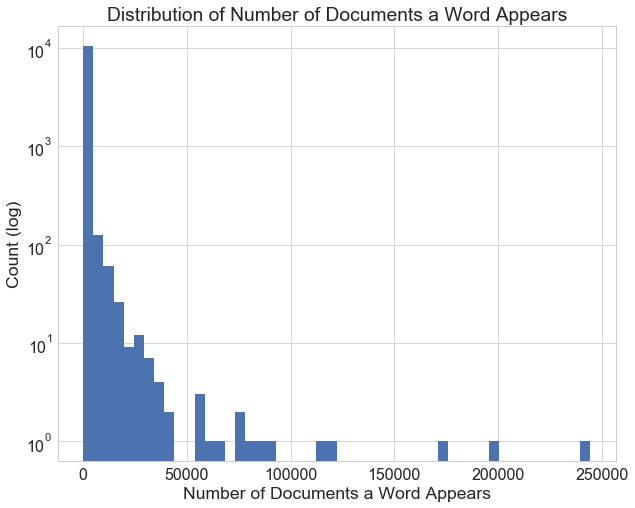

In [9]:
#Calculate 'count' as the number of documents that a word appears 
count=(rev_vectorized>0).sum(axis=0).A.tolist()[0]#count as 1 if the word appear in a document regardless how many times it appear
plt.hist(count,bins=50,log=True)
plt.xlabel('Number of Documents a Word Appears')
plt.ylabel('Count (log)')
plt.title('Distribution of Number of Documents a Word Appears');

The distribution is very long-tailed. Some of the words appear in too many documents.

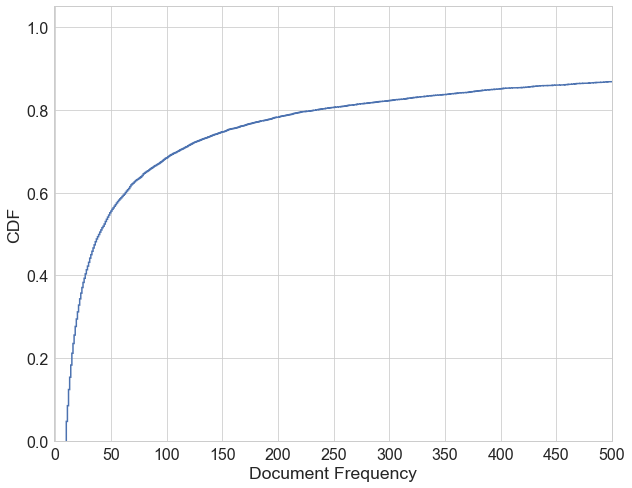

In [10]:
#Construct the cumulative distribution of document frequencies (df)
plt.hist(count,bins=np.unique(count),cumulative=True,density=True,histtype='step',linewidth=1.5);
plt.xlabel('Document Frequency')
plt.ylabel('CDF')
plt.xticks(np.arange(0,501,50))
plt.xlim(-1,500);



This CDF plot justified us in setting 'min_df'=10 around which the curve starts to climb steeply.

In [11]:
# Word feature in each column of the transformed matrix
wfeatures=c_vec.get_feature_names()
print("Lengh of features:",len(wfeatures))

Lengh of features: 10670


In [12]:
# Word and its count
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
print('\n Top 10 Features in the bag-of-word and the counts:\n')
pd.DataFrame(sorted(d.items(),key=lambda x: x[1],reverse=True)[:10],columns=['word','count'])


 Top 10 Features in the bag-of-word and the counts:



,word,count
0,room,376243
1,staff,218196
2,location,178012
3,good,145318
4,breakfast,135939
5,great,106319
6,bed,97308
7,friendly,83682
8,clean,81072
9,helpful,76320


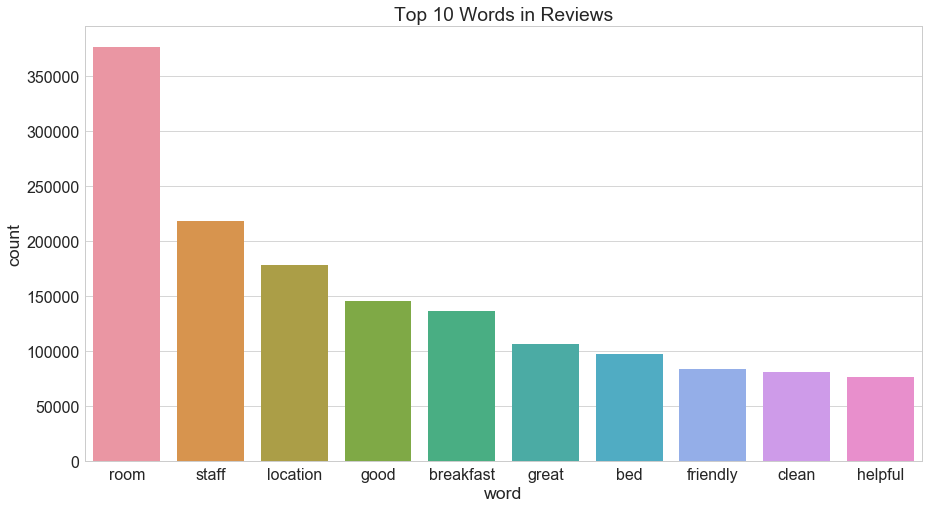

In [13]:
# Visualize counts of words
d=dict(zip(wfeatures, np.ravel(rev_vectorized.sum(axis=0))))
w_c=pd.DataFrame.from_dict((d),orient='index').reset_index()
w_c.columns=('word','count')
w_c=w_c.sort_values(by='count',ascending=False)

plt.figure(figsize=(15,8))
sns.barplot(x='word', y='count', data=w_c.head(10).sort_values('count',ascending=False))            
plt.title("Top 10 Words in Reviews");

### LDA Model 

The reviews have both negative and positive part. Will the model be able to separate reviews into positive and negative ones? Since topic-modeling can be quite time-consuming and the data is quite large, let's build a 2-topic model to explore this issue. 

In [14]:
 for num,message in enumerate(rev_lemmatized[:10]):
    print(num,message)
    print ('\n')

0 angry make post available possible site use plan trip make mistake book place make booking book com stay night arrival place small room floor turn room book specially reserve level duplex room would big window high ceiling room mind break window close hello rain mini fridge contain sort bio weapon least guess smell intimately ask change room explain time book duplex btw cost simple double get way volume due high ceiling offer room next day check next day clock order get room wan good way begin holiday wait order check new room wonderful waist time room get want peaceful internal garden view big window tired waiting room place belonging rush city evening turn constant noise room guess make vibrate vent tube something constant annoying hell stop even make hard fall asleep wife audio recording attach want send mail next day technician come able determine because disturb sound offer change room fully book room leave small seem new park beautiful


1  real complaint great great location s

In [15]:
import timeit
start_time = timeit.default_timer()


lda_modeln2 = LDA(n_components=2,          
                  max_iter=10, # default max learning iterations: 10. with the sample, this code takes mins
                  learning_method='online',   
                  random_state=100,          # Random state
                  batch_size=128,            # default num docs in each learning iter
                  evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                  n_jobs =1,               # Dont't use all available CPUs
                  )

lda_modeln2.fit(rev_vectorized)
lda_output = lda_modeln2.transform(rev_vectorized)

lda_n2_LogLikelihood=lda_modeln2.score(rev_vectorized)
lda_n2_perp=lda_modeln2.perplexity(rev_vectorized)

elapsed = timeit.default_timer() - start_time 
print('time',elapsed)

time 1159.0400845250006


In [16]:
# Save model using pickle
filename = 'lda_modeln2.sav'
pickle.dump(lda_modeln2, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
lda_modeln2 = pickle.load(open(filename, 'rb'))

In [17]:
# See model parameters
print('Model parameters:')
pprint(lda_modeln2.get_params())

#----Diagnose model performance with perplexity and log-likelihood---
# Log Likelyhood: Higher the better
print("\nLog Likelihood Score: %.2f" %lda_n2_LogLikelihood) 

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("\nPerplexity: %.2f" %lda_n2_perp) 



Model parameters:
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': 0,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 2,
 'n_jobs': 1,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}

Log Likelihood Score: -49818074.95

Perplexity: 703.10


In [18]:
# Define a function to display topics
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))
        
        
num_top_words = 50
feature_names=c_vec.get_feature_names()
display_topics(lda_modeln2, feature_names, num_top_words)

Topic 0:
room bed staff night good shower check breakfast day bathroom location time work small reception stay make book floor ask pay service need clean door water window use air poor nice hot bad noise come coffee say star open noisy charge leave morning sleep look tell people old arrive really
Topic 1:
staff room location good breakfast great friendly helpful nice clean excellent comfortable bed stay close restaurant station walk really lovely bar perfect city small view area bit little service food metro quiet amazing price facility minute modern easy love place central pool expensive spacious fantastic train london big comfy beautiful


Topic 0 contains some negative words while topic 1 is positive. Since we have limited computing resources, we pick n_components=5 for display purpose. We will compare accuracy score in machine learning part for larger n_components=5,10... to analyze how n_components affects the model performance.

In [39]:
import time
start_time = time.time()


lda_modeln5 = LDA(n_components=5,          
                  max_iter=10, # default max learning iterations: 10. takes 3mins
                  learning_method='online',   
                  random_state=100,          # Random state
                  batch_size=128,            # default num docs in each learning iter
                  evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                  n_jobs =1,               # Don't use all available CPUs
                  )
lda_modeln5.fit(rev_vectorized)
lda_output = lda_modeln5.transform(rev_vectorized)

print("--- %s seconds ---" % (time.time() - start_time))



--- 1165.3222079277039 seconds ---


In [40]:
import time
start_time = time.time()


lda_n5_LogLikelihood=lda_modeln5.score(rev_vectorized)
lda_n5_perp=lda_modeln5.perplexity(rev_vectorized)

#----Diagnose model performance with perplexity and log-likelihood---
# Log Likelyhood: Higher the better
print("\nLog Likelihood Score: %.2f" %lda_n5_LogLikelihood) 

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("\nPerplexity: %.2f" %lda_n5_perp) 

print("--- %s seconds ---" % (time.time() - start_time))




Log Likelihood Score: -50135369.38

Perplexity: 733.08
--- 190.90268898010254 seconds ---


In [41]:
num_top_words = 50
feature_names=c_vec.get_feature_names()
display_topics(lda_modeln5, feature_names, num_top_words)

Topic 0:
bed room bathroom shower comfortable small comfy clean nice water good location pillow big bath size great coffee double large bedroom really little towel space bit single tea hard lovely spacious make toilet light quiet use uncomfortable view modern design sleep floor need soft free low door mattress area glass
Topic 1:
staff breakfast room location friendly helpful good great excellent clean nice bar food comfortable service lovely really restaurant facility stay perfect price amazing coffee little expensive view small bit choice fantastic love extremely buffet beautiful quality reception drink tea area free wifi include spacious wonderful modern definitely polite pleasant quiet
Topic 2:
location close walk station good great city metro nice restaurant pool minute easy room area clean train centre value parking min breakfast central center far tram distance away place street park bus quiet stay right perfect excellent locate money tube stop london bit access comfortable view

In [42]:
# Save model using pickle
filename = 'lda_modeln5.sav'
pickle.dump(lda_modeln5, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
lda_modeln5 = pickle.load(open(filename, 'rb'))

In [ ]:
# # GridSearch will Take several hours
# import warnings
# warnings.filterwarnings('ignore')


# # Define Search Param
# search_params = {'n_components': [5, 50, 100]}

# # Init the Model
# lda = LDA(n_jobs=1,random_state=100)

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params) 

# # Do the Grid Search
# model.fit(rev_vectorized)

# # Show the best topic model and its parameters

# # Best Model
# best_lda_model = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: %.2f" %(model.best_score_))

# # Perplexity
# print("Model Perplexity: %.2f" %( best_lda_model.perplexity(rev_vectorized)))


# #Save the best_lda_model

# # # Save model using pickle
# filename = 'best_lda.sav'
# pickle.dump(best_lda_model, open(filename, 'wb'))
 
# # some time later...
 
# # load the model from disk
# best_lda_model = pickle.load(open(filename, 'rb'))

### Dominant Topic in each Document

What particular topic does a document belong to? A dominant topic in a document is spotted by finding the topic that has the highest contributions (revealed by the document-topic matrix) to that document. We will first display top 20 keywords in all the topics and then make a table to show all major topics in a document and specify the most dominant topic in that document.

#### Display keywords in topics

In [43]:
num_top_words = 20
feature_names=c_vec.get_feature_names()
print('Top 20 Words in topics found in the 5-topic lda_model')
display_topics(lda_modeln5, feature_names, num_top_words)

Top 20 Words in topics found in the 5-topic lda_model
Topic 0:
bed room bathroom shower comfortable small comfy clean nice water good location pillow big bath size great coffee double large
Topic 1:
staff breakfast room location friendly helpful good great excellent clean nice bar food comfortable service lovely really restaurant facility stay
Topic 2:
location close walk station good great city metro nice restaurant pool minute easy room area clean train centre value parking
Topic 3:
stay staff check room time day book make pay ask service reception night say charge come tell help leave extra
Topic 4:
room location good work night breakfast floor window air door noise star open noisy small old bad need clean poor


Topic 0 mentioned facilities in the hotel, i.e.,'room', 'shower', 'water', 'location', 'pillow'.<br>
Topic 1 mentioned 'staff', 'location', food ('breakfast', 'bar', 'restaurant'), 'service'.<br>
Topic 2 talks about 'lcoation', 'transport', 'restaurant','parking'.<br>
Topic 3 talks about 'staff', 'receptoin', 'service'.<br>
Topic 4 talks about some negative aspects 'noise', 'small', 'old', 'bad', 'poor'.<br>

#### Make a  Document - Topic Table 

In [44]:
# Create Document - Topic Matrix
lda_output=lda_modeln5.transform(rev_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_modeln5.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df_txt))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topics = df_document_topic.head(10)
df_document_topics


,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.03,0.00,0.07,0.47,0.43,3
Doc1,0.12,0.45,0.11,0.32,0.00,1
Doc2,0.20,0.41,0.01,0.12,0.26,1
Doc3,0.08,0.00,0.06,0.25,0.60,4
Doc4,0.00,0.00,0.06,0.68,0.26,3
Doc5,0.01,0.38,0.30,0.16,0.14,1
Doc6,0.89,0.01,0.08,0.01,0.01,0
Doc7,0.01,0.88,0.09,0.01,0.01,1
Doc8,0.22,0.02,0.02,0.34,0.41,4
Doc9,0.27,0.22,0.25,0.01,0.26,0


#### Visualize topics distribution across documents

In [45]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num_Documents")
df_topic_distribution.columns = ['Topic', 'Num_Documents']
df_topic_distribution

,Topic,Num_Documents
0,1,153341
1,2,78369
2,3,75114
3,4,65793
4,0,56847


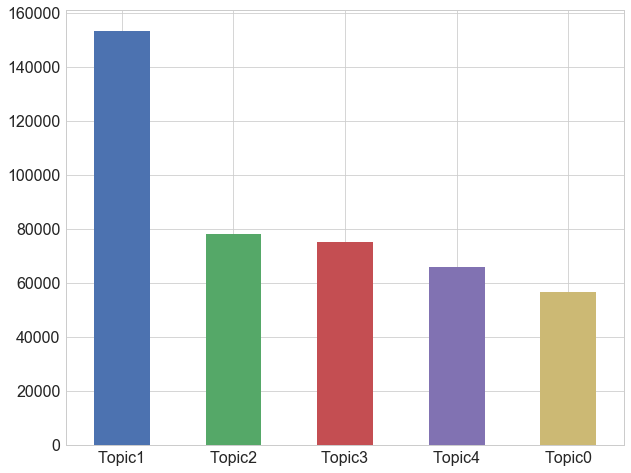

In [46]:
# Visualize the topic distributions across sampled documents
df_topic_distribution['Num_Documents'].plot(kind='bar',rot=0)
plt.xticks(np.arange(0,5),'Topic'+df_topic_distribution['Topic'].astype('str'));

Most of the documents in our sample seems to about Topic1. 

### Visualize the LDA Model with pyLDAvis 

In [48]:
import time
start_time = time.time()


pyLDAvis.enable_notebook()
lda_display_sk= pyLDAvis.sklearn.prepare(lda_modeln5, rev_vectorized, c_vec, mds='tsne')
print("--- %s seconds ---" % (time.time() - start_time))#10:37-10:38

# Save the visualization in a html format
pyLDAvis.save_html(lda_display_sk, 'skldan5.html')


lda_display_sk




--- 69.64540910720825 seconds ---


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
1      24.981592        1       1  151.945648 -108.520294
3      22.721737        1       2  -25.139259 -175.862152
4      18.682259        1       3   57.242630   -5.324613
2      18.410679        1       4   97.995369 -243.457733
0      15.203733        1       5  -81.867287  -47.350636, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
843    Default   98758.000000          bed   98758.000000  30.0000  30.0000
8900   Default  211354.000000        staff  211354.000000  29.0000  29.0000
3879   Default   80403.000000     friendly   80403.000000  28.0000  28.0000
8008   Default  369911.000000         room  369911.000000  27.0000  27.0000
4427   Default   74356.000000      helpful   74356.000000  26.0000  26.0000
1137   Default  140570.000000    breakfast  140570.000000  25.0000  25.0000
8456   Default   35152.000000       shower   35152.000000  24.0000  24.0000
795    Default   45774.000000     bathroom   45774.000000  23.0000  23.0000
10345  Default   36392.000000         walk   36392.000000  22.0000  22.0000
8956   Default   36350.000000      station   36350.000000  21.0000  21.0000
4192   Default  104244.000000        great  104244.000000  20.0000  20.0000
1764   Default   40649.000000        close   40649.000000  19.0000  19.0000
5462   Default  173833.000000     location  173833.000000  18.0000  18.0000
3354   Default   57183.000000    excellent   57183.000000  17.0000  17.0000
1571   Default   33777.000000        check   33777.000000  16.0000  16.0000
10581  Default   27482.000000         work   27482.000000  15.0000  15.0000
1876   Default   61678.000000  comfortable   61678.000000  14.0000  14.0000
1674   Default   25840.000000         city   25840.000000  13.0000  13.0000
4113   Default  147976.000000         good  147976.000000  12.0000  12.0000
1884   Default   20165.000000        comfy   20165.000000  11.0000  11.0000
3762   Default   27087.000000         food   27087.000000  10.0000  10.0000
8961   Default   66914.000000         stay   66914.000000   9.0000   9.0000
5861   Default   21424.000000        metro   21424.000000   8.0000   8.0000
1046   Default   24008.000000         book   24008.000000   7.0000   7.0000
8616   Default   54293.000000        small   54293.000000   6.0000   6.0000
8340   Default   43905.000000      service   43905.000000   5.0000   5.0000
7844   Default   37157.000000   restaurant   37157.000000   4.0000   4.0000
10534  Default   18126.000000       window   18126.000000   3.0000   3.0000
2444   Default   34023.000000          day   34023.000000   2.0000   2.0000
9560   Default   36149.000000         time   36149.000000   1.0000   1.0000
...        ...            ...          ...            ...      ...      ...
9787    Topic5    1995.888008          tub    1996.688074   1.8832  -6.3611
10367   Topic5    1790.038994     wardrobe    1790.837398   1.8832  -6.4700
8529    Topic5    3379.166500         sink    3382.014321   1.8828  -5.8346
8528    Topic5    7630.133947       single    7739.590833   1.8694  -5.0201
795     Topic5   37730.957948     bathroom   45774.372988   1.6904  -3.4217
2904    Topic5   10112.959433       double   11828.225315   1.7270  -4.7384
8758    Topic5    8440.622856        space   10149.448024   1.6993  -4.9191
4345    Topic5    6878.666565         hard    8058.074918   1.7254  -5.1238
10398   Topic5   14479.767964        water   19713.550762   1.5751  -4.3794
5126    Topic5    3565.674490       kettle    3994.362312   1.7701  -5.7808
8547    Topic5   10426.377389         size   15936.321910   1.4594  -4.7079
5237    Topic5    9697.799687        large   14966.263537   1.4497  -4.7803
8616    Topic5   25807.405112        small   54293.192921   1.1399  -3.8015
1876    Topic5   27137.080615  comfortable   61678.0614

![title](img/ldavis_skn5.png)
For an interactive visualization, click [here]( https://houhouskldan5.herokuapp.com/)

In [23]:
import time
start_time = time.time()


lda_modeln10 = LDA(n_components=10,          
                  max_iter=10, # default max learning iterations: 10. takes 3mins
                  learning_method='online',   
                  random_state=100,          # Random state
                  batch_size=128,            # default num docs in each learning iter
                  evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                  n_jobs =1,               # Don't use all available CPUs
                  )
lda_modeln10.fit(rev_vectorized)
lda_output = lda_modeln10.transform(rev_vectorized)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1175.9741010665894 seconds ---


In [24]:
import time
start_time = time.time()


lda_n10_LogLikelihood=lda_modeln10.score(rev_vectorized)
lda_n10_perp=lda_modeln10.perplexity(rev_vectorized)

#----Diagnose model performance with perplexity and log-likelihood---
# Log Likelyhood: Higher the better
print("\nLog Likelihood Score: %.2f" %lda_n10_LogLikelihood) 

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("\nPerplexity: %.2f" %lda_n10_perp) 

print("--- %s seconds ---" % (time.time() - start_time))




Log Likelihood Score: -51242300.38

Perplexity: 848.02
--- 193.20553016662598 seconds ---


In [25]:
# Save model using pickle
filename = 'lda_modelskn10.sav'
pickle.dump(lda_modeln10, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
lda_modeln10 = pickle.load(open(filename, 'rb'))




In [26]:
#Visualize the LDA Model with pyLDAvis
import time
start_time = time.time()

pyLDAvis.enable_notebook()
lda_display_sk= pyLDAvis.sklearn.prepare(lda_modeln10, rev_vectorized, c_vec, mds='tsne')
print("--- %s seconds ---" % (time.time() - start_time))

# Save the visualization in a html format
pyLDAvis.save_html(lda_display_sk, 'skldan10.html')

lda_display_sk




--- 80.00818204879761 seconds ---


PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
8      18.078260        1       1   22.612886 -197.633316
3      13.535366        1       2 -499.910706  -37.769455
6      12.765649        1       3 -309.911194  357.264008
2      12.314550        1       4  386.309937 -185.431793
9      10.942761        1       5 -283.124969 -357.670685
4      10.352337        1       6 -181.193207   50.437412
5       7.772176        1       7  122.625595 -506.962860
7       5.568091        1       8  135.499069  102.663742
1       4.435114        1       9   63.256847  432.764008
0       4.235697        1      10  442.809357  213.624420, topic_info=      Category           Freq         Term          Total  loglift  logprob
term                                                                       
8900   Default  211214.000000        staff  211214.000000  30.0000  30.0000
8008   Default  365119.000000         room  365119.000000  29.0000  29.0000
843    Default   95067.000000          bed   95067.000000  28.0000  28.0000
3879   Default   80459.000000     friendly   80459.000000  27.0000  27.0000
4427   Default   74845.000000      helpful   74845.000000  26.0000  26.0000
1137   Default  140227.000000    breakfast  140227.000000  25.0000  25.0000
8961   Default   67974.000000         stay   67974.000000  24.0000  24.0000
5462   Default  171764.000000     location  171764.000000  23.0000  23.0000
3354   Default   56195.000000    excellent   56195.000000  22.0000  22.0000
4192   Default  103988.000000        great  103988.000000  21.0000  21.0000
10345  Default   36531.000000         walk   36531.000000  20.0000  20.0000
8956   Default   36488.000000      station   36488.000000  19.0000  19.0000
4113   Default  145958.000000         good  145958.000000  18.0000  18.0000
1764   Default   40945.000000        close   40945.000000  17.0000  17.0000
7091   Default   19168.000000         pool   19168.000000  16.0000  16.0000
1876   Default   60313.000000  comfortable   60313.000000  15.0000  15.0000
1571   Default   33527.000000        check   33527.000000  14.0000  14.0000
297    Default   21552.000000      amazing   21552.000000  13.0000  13.0000
3709   Default   23412.000000        floor   23412.000000  12.0000  12.0000
795    Default   44413.000000     bathroom   44413.000000  11.0000  11.0000
7094   Default   16592.000000         poor   16592.000000  10.0000  10.0000
8456   Default   34294.000000       shower   34294.000000   9.0000   9.0000
193    Default   16391.000000          air   16391.000000   8.0000   8.0000
1815   Default   22903.000000       coffee   22903.000000   7.0000   7.0000
8616   Default   53144.000000        small   53144.000000   6.0000   6.0000
1046   Default   23840.000000         book   23840.000000   5.0000   5.0000
1712   Default   81809.000000        clean   81809.000000   4.0000   4.0000
10518  Default   20455.000000         wifi   20455.000000   3.0000   3.0000
6745   Default   16145.000000      parking   16145.000000   2.0000   2.0000
1674   Default   26096.000000         city   26096.000000   1.0000   1.0000
...        ...            ...          ...            ...      ...      ...
4428   Topic10    2444.181052     helpfull    2445.079392   3.1613  -4.8805
3358   Topic10    2378.896716  exceptional    2379.795057   3.1612  -4.9076
1695   Topic10    2340.473301        class    2341.371637   3.1612  -4.9239
9356   Topic10    2305.545814        taste    2306.444188   3.1612  -4.9389
398    Topic10    2195.835638    apartment    2196.733983   3.1612  -4.9876
5368   Topic10    2123.526967     lighting    2124.425294   3.1612  -5.0211
9289   Topic10    2113.804129         swim    2114.702499   3.1612  -5.0257
2096   Topic10    2101.875929  continental    2102.774241   3.1612  -5.0314
5490   Topic10    1994.666272       longer    1995.564638   3.1612  -5.0837
103    Topic10    1913.450222   additional    1914.348597   3.1612  -

In [29]:
import time
start_time = time.time()


lda_modeln50 = LDA(n_components=50,          
                  max_iter=10, # default max learning iterations: 10. takes 3mins
                  learning_method='online',   
                  random_state=100,          # Random state
                  batch_size=128,            # default num docs in each learning iter
                  evaluate_every = 0,       # compute perplexity every n iters, default: Don't
                  n_jobs =1,               # Don't use all available CPUs
                  )
lda_modeln50.fit(rev_vectorized)
lda_output = lda_modeln50.transform(rev_vectorized)

print("--- %s seconds ---" % (time.time() - start_time))

--- 1898.5829229354858 seconds ---


In [30]:
import time
start_time = time.time()


lda_n50_LogLikelihood=lda_modeln50.score(rev_vectorized)
lda_n50_perp=lda_modeln50.perplexity(rev_vectorized)

#----Diagnose model performance with perplexity and log-likelihood---
# Log Likelyhood: Higher the better
print("\nLog Likelihood Score: %.2f" %lda_n50_LogLikelihood) 

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("\nPerplexity: %.2f" %lda_n50_perp) 

print("--- %s seconds ---" % (time.time() - start_time))





Log Likelihood Score: -67862420.14

Perplexity: 7554.74
--- 195.3739049434662 seconds ---


In [31]:
# Save model using pickle
filename = 'lda_modelskn50.sav'
pickle.dump(lda_modeln50, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
lda_modeln50 = pickle.load(open(filename, 'rb'))




In [32]:
#Visualize the LDA Model with pyLDAvis
import time
start_time = time.time()

pyLDAvis.enable_notebook()
lda_display_sk= pyLDAvis.sklearn.prepare(lda_modeln50, rev_vectorized, c_vec, mds='tsne')
print("--- %s seconds ---" % (time.time() - start_time))

# Save the visualization in a html format
pyLDAvis.save_html(lda_display_sk, 'skldan50.html')

lda_display_sk



--- 83.15779519081116 seconds ---


PreparedData(topic_coordinates=           Freq  cluster  topics           x           y
topic                                                   
49     5.840861        1       1  -47.525463   51.759876
24     5.702259        1       2  -54.184055  -43.441448
30     4.286256        1       3  -55.474571  -12.517983
7      3.797412        1       4   15.574606  -76.695374
14     3.522514        1       5   20.244390  -12.892415
35     3.221928        1       6   50.157166   33.794262
1      2.932733        1       7   48.681469  -24.682575
41     2.896096        1       8  -60.811626   24.039476
10     2.728356        1       9   26.549030  -49.452404
19     2.670385        1      10   37.424393    9.452066
29     2.659925        1      11  -15.896971  -73.217194
48     2.587059        1      12    7.471694   15.012924
32     2.499147        1      13   52.589417   78.816223
13     2.460523        1      14  -24.862152  -40.351551
31     2.179149        1      15   75.982307   10.604983
0      2.141641        1      16   86.556503   46.476509
33     2.033768        1      17  123.759407  -20.106863
43     2.024761        1      18  -25.534052   -3.666544
8      1.984048        1      19  -15.304291 -111.233406
17     1.917452        1      20   26.658850   91.117241
40     1.837752        1      21  115.505775  -70.033821
18     1.793198        1      22  -76.458374 -112.890465
27     1.774985        1      23    0.291226  149.055374
44     1.732633        1      24   25.967712  136.338516
39     1.701334        1      25 -101.632942   -3.209328
25     1.613091        1      26  -26.186987   24.242588
20     1.593783        1      27   93.883621  104.138268
26     1.560981        1      28   84.910957  -22.962221
42     1.545396        1      29  -45.235012 -146.568085
2      1.502708        1      30  -94.960983   49.791908
9      1.482125        1      31  -63.929585   95.866859
45     1.477865        1      32  138.538116   16.958881
3      1.463345        1      33  160.273895   79.684982
38     1.446179        1      34  -51.344975  -82.859879
47     1.403925        1      35   11.011158   49.352722
22     1.320087        1      36  -84.845009  -55.870056
16     1.213728        1      37  167.852859    7.754310
28     1.203150        1      38 -121.952377  -92.640907
34     1.177000        1      39 -130.499817  -16.407900
6      1.172352        1      40   -4.292061  -28.145344
46     1.161922        1      41   66.715340  -63.590107
21     1.098983        1      42  146.216919  -79.183617
4      1.085688        1      43  -16.204002   87.515404
23     1.080434        1      44   63.083588 -237.478333
37     1.043419        1      45  119.939156   51.873699
15     1.020466        1      46   16.074289 -157.818146
11     0.968533        1      47 -107.564690  181.222610
12     0.868454        1      48   42.231144 -114.143425
5      0.796401        1      49   73.253357 -154.994751
36     0.773812        1      50   91.658073 -111.095978, topic_info=      Category           Freq          Term          Total  loglift  logprob
term                                                                        
4113   Default  147959.000000          good  147959.000000  30.0000  30.0000
8900   Default  214277.000000         staff  214277.000000  29.0000  29.0000
8008   Default  372260.000000          room  372260.000000  28.0000  28.0000
4192   Default  106196.000000         great  106196.000000  27.0000  27.0000
3354   Default   60164.000000     excellent   60164.000000  26.0000  26.0000
1137   Default  146761.000000     breakfast  146761.000000  25.0000  25.0000
843    Default   96170.000000           bed   96170.000000  24.0000  24.0000
3879   Default   80324.000000      friendly   80324.000000  23.0000  23.0000
4427   Default   74292.000000       helpful   74292.000000  22.0000  22.0000
1876   Default   62366.000000   comfortable   62366.000000  21.0000  21.0000
8961   Default   71284.000000          stay   71284.000000  20.0000  

Using matplotlib backend: MacOSX


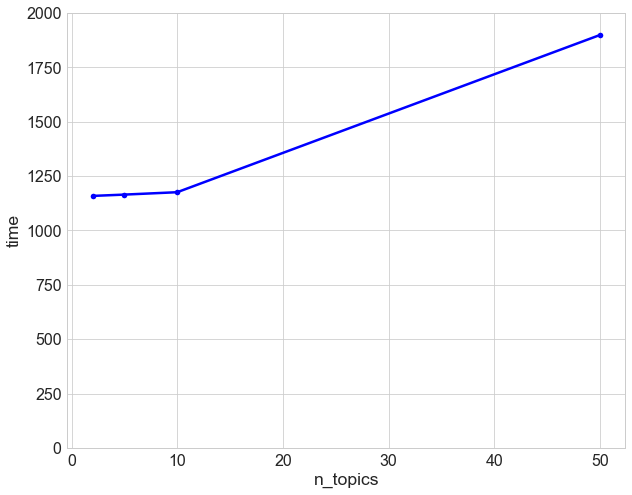

In [100]:
import matplotlib.pyplot as plt
%matplotlib
plt.plot([2,5,10,50],[1159,1165,1176,1899],'bo-')
plt.ylim(0,2000)
plt.xlabel('n_topics')
plt.ylabel('time');

## Build LDA Model with Gensim
Since the LDA model with sklearn takes lots of computing resources for larger number of topics and Gensim is more efficient in topic modeling, we turn to gensim for building the LDA model. For gensim we need to tokenize the data and filter out stopwords. 

### Create the Dictionary and Corpus Needed for Topic Modeling
Since the size of reviews is quite large, we randomly select some samples to train the model. We can evaluate our topic models by the holdout test set.

In [56]:
from sklearn.model_selection import train_test_split


itrain, itest = train_test_split(range(df_txt.shape[0]), train_size=0.7,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True

rev_gens=df_txt['Rev_Lemmatized'][mask]



In [57]:
#Prepare NLTK stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['hotel'])



# Tokenize and clean sentences to words 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations



def process_text(sentences):
    # Create Corpus
    txt_tokenized=list(sent_to_words(sentences))
    # Remove stopwords
    txt_tokenized = [[w for w in doc if w not in stop_words] for doc in txt_tokenized]
    return txt_tokenized


import warnings
warnings.filterwarnings('ignore')

import timeit
start_time = timeit.default_timer()


rev_tokenized=process_text(rev_gens)
    # Create Dictionary-association word to numericID
dictionary = gensim.corpora.Dictionary(rev_tokenized )
    # Term Document Frequency-transform collections of texts to numeric form
corpus = [dictionary.doc2bow(txt) for txt in rev_tokenized ]

    # #View the first document:[(word_id,count ),()...]
print(corpus[:1])


    #save dictionary and corpus
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

elapsed = timeit.default_timer() - start_time #10:41-10:10:43
print ('time', elapsed)


[[(0, 1), (1, 5), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 5), (11, 3), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 2), (18, 13), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 1), (26, 2), (27, 3), (28, 2), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 2), (43, 1), (44, 1), (45, 1), (46, 2), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 3), (54, 2), (55, 1), (56, 1), (57, 2), (58, 3), (59, 3), (60, 2), (61, 1), (62, 2), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 2), (69, 1), (70, 1), (71, 2), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 1), (109, 1), (110, 1

In [59]:
def build_lda(revs,ntopics,passes=15,num_words=10):
    """Tokenize and clean reviews by process_text, then create dictionary and corpus and build LDA model"""
#     rev_tokenized=process_text(revs)
#     #Create Dictionary-association word to numericID
#     dictionary = gensim.corpora.Dictionary(rev_tokenized )
#     #Term Document Frequency-transform collections of texts to numeric form
#     corpus = [dictionary.doc2bow(txt) for txt in rev_tokenized ]

#     #View the first document:[(word_id,count ),()...]
#     # print(corpus[:1])


#     #save dictionary and corpus
#     pickle.dump(corpus, open('corpus.pkl', 'wb'))
#     dictionary.save('dictionary.gensim')

    #build lda model
    ldamodel=gensim.models.ldamodel.LdaModel(corpus, num_topics = ntopics, id2word=dictionary, passes=15,random_state=100)
    #ldamodel = gensim.models.ldamulticore.LdaMulticore(corpus, num_topics =ntopics, id2word=dictionary, passes=15,random_state=100) #Multicore very demanding on memory; can do for ntopics=10 but not 50 +
    
    #save ldamodel
    ldamodel.save('model{0}.gensim'.format(ntopics))
    topics = ldamodel.print_topics(num_words=10)
    for topic in topics:
        print('Topics:\n',topic)
    
    return ntopics

import timeit
start_time = timeit.default_timer()


ntopics=5

_=build_lda(rev_gens,ntopics=ntopics,passes=15)
elapsed = timeit.default_timer() - start_time #10:45-10:
print ('time', elapsed)




Topics:
 (0, '0.070*"breakfast" + 0.061*"room" + 0.061*"staff" + 0.049*"good" + 0.043*"location" + 0.028*"friendly" + 0.027*"great" + 0.026*"clean" + 0.023*"helpful" + 0.022*"nice"')
Topics:
 (1, '0.030*"room" + 0.016*"check" + 0.015*"get" + 0.014*"day" + 0.012*"time" + 0.011*"ask" + 0.011*"pay" + 0.011*"book" + 0.010*"night" + 0.010*"reception"')
Topics:
 (2, '0.049*"staff" + 0.040*"stay" + 0.019*"would" + 0.018*"helpful" + 0.018*"great" + 0.015*"friendly" + 0.015*"nothing" + 0.014*"location" + 0.013*"room" + 0.013*"everything"')
Topics:
 (3, '0.036*"close" + 0.034*"station" + 0.030*"walk" + 0.027*"location" + 0.023*"metro" + 0.022*"city" + 0.019*"good" + 0.015*"minute" + 0.013*"easy" + 0.013*"train"')
Topics:
 (4, '0.090*"room" + 0.032*"bed" + 0.020*"bathroom" + 0.020*"small" + 0.019*"location" + 0.017*"shower" + 0.015*"good" + 0.012*"floor" + 0.011*"clean" + 0.011*"nice"')
time 4598.367434919004


In [60]:
ntopics=5
ldamodel = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))

import timeit
start_time = timeit.default_timer()


print('num_topic: %d' %ntopics)
    
# Compute Perplexity
log_perplexity=ldamodel.log_perplexity(corpus)
print('\nPerplexity: %.2f' %(log_perplexity))  # a measure of how good the model is. lower the better.



# Compute Coherence Score
coherence_ldamodel= CoherenceModel(model=ldamodel, texts=rev_tokenized, dictionary=dictionary, coherence='c_v')
coherence= coherence_ldamodel.get_coherence()
print('\nCoherence Score: %.2f' %coherence)

elapsed = timeit.default_timer() - start_time #10:45-10:
print ('time', elapsed)



num_topic: 5

Perplexity: -6.84

Coherence Score: 0.58
time 555.498392251


### Model Perplexity
The coherence takes too long (more than 24 hours for larger ntopics= 50,...) to calculate. ntopics=5 takes 1hour 20mins. So we investigate the model performance by the figure below: ntopics v.s. perplexity. Note the data are obtained by calculations on a cluster.

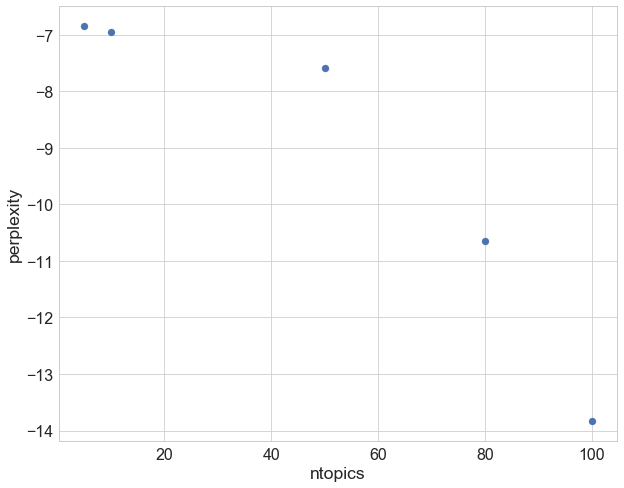

In [123]:
df_ntopic_perp=pd.DataFrame([(5,-6.85),(10,-6.95),(50,-7.58),(80,-10.65),(100,-13.83)],columns=['ntopics','perplexity'])
df_ntopic_perp.plot(kind='scatter',x='ntopics',y='perplexity',s=50);

### Visualize topics distribution across documents

In [61]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))

ntopics=5
ldan5 = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))

topics = ldan5.print_topics(num_words=10)
for topic in topics:
    print('Topics:\n',topic)

Topics:
 (0, '0.070*"breakfast" + 0.061*"room" + 0.061*"staff" + 0.049*"good" + 0.043*"location" + 0.028*"friendly" + 0.027*"great" + 0.026*"clean" + 0.023*"helpful" + 0.022*"nice"')
Topics:
 (1, '0.030*"room" + 0.016*"check" + 0.015*"get" + 0.014*"day" + 0.012*"time" + 0.011*"ask" + 0.011*"pay" + 0.011*"book" + 0.010*"night" + 0.010*"reception"')
Topics:
 (2, '0.049*"staff" + 0.040*"stay" + 0.019*"would" + 0.018*"helpful" + 0.018*"great" + 0.015*"friendly" + 0.015*"nothing" + 0.014*"location" + 0.013*"room" + 0.013*"everything"')
Topics:
 (3, '0.036*"close" + 0.034*"station" + 0.030*"walk" + 0.027*"location" + 0.023*"metro" + 0.022*"city" + 0.019*"good" + 0.015*"minute" + 0.013*"easy" + 0.013*"train"')
Topics:
 (4, '0.090*"room" + 0.032*"bed" + 0.020*"bathroom" + 0.020*"small" + 0.019*"location" + 0.017*"shower" + 0.015*"good" + 0.012*"floor" + 0.011*"clean" + 0.011*"nice"')


In [62]:
def gensim_lda_feature(doc,dictionary,corpus,num_topics,ldamodel):
    """extract document-topic matrix from gensim lda and convert it into a form ready to be used for prediction """
    
    # Create document-topic-matrix for new documents
    doc_tokenized=process_text(doc)
    doc_bow=[dictionary.doc2bow(d) for d in doc_tokenized]
    dtm=ldamodel.get_document_topics(doc_bow)

        # Convert dtm to numpy array
    dtm_csr = gensim.matutils.corpus2csc(dtm)
    dtm_numpy = dtm_csr.T.toarray()

    return dtm_numpy

In [63]:

import timeit
start_time = timeit.default_timer()


dtm=gensim_lda_feature(df_txt['Rev_Lemmatized'],dictionary,corpus,ntopics,ldan5)
# column names
tnames = ["Topic" + str(i) for i in range(5)]

# index names
dnames = ["Doc" + str(i) for i in range(len(df_txt['Rev_Lemmatized']))]

# Make the pandas dataframe
df_doc_topic = pd.DataFrame(np.round(dtm, 2), columns=tnames, index=dnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_doc_topic.values, axis=1)
df_doc_topic['dominant_topic'] = dominant_topic

elapsed = timeit.default_timer() - start_time #
print ('time', elapsed)

time 415.2234045669975


In [64]:
df_doc_topics = df_doc_topic.head(10)
df_doc_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Doc0,0.00,0.63,0.05,0.06,0.26,1
Doc1,0.29,0.21,0.42,0.00,0.08,2
Doc2,0.42,0.30,0.00,0.00,0.26,0
Doc3,0.00,0.48,0.03,0.10,0.38,1
Doc4,0.06,0.57,0.25,0.04,0.08,1
Doc5,0.01,0.21,0.20,0.49,0.10,3
Doc6,0.00,0.24,0.11,0.11,0.53,4
Doc7,0.67,0.01,0.12,0.07,0.12,0
Doc8,0.01,0.52,0.01,0.01,0.45,1
Doc9,0.26,0.11,0.00,0.24,0.39,4


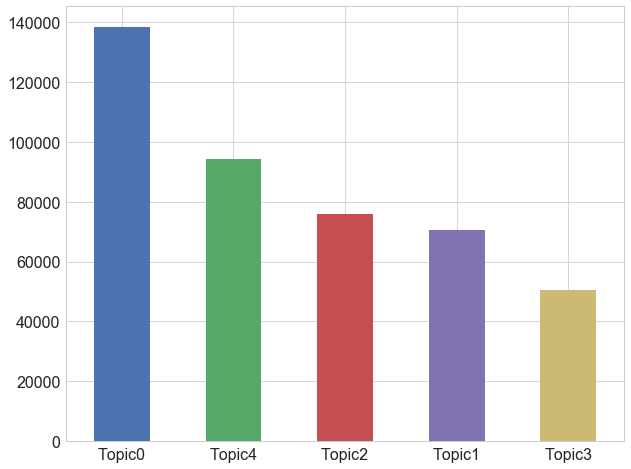

In [65]:
df_topic_distribution = df_doc_topic['dominant_topic'].value_counts().reset_index(name="Num_Documents")
df_topic_distribution.columns = ['Topic', 'Num_Documents']
df_topic_distribution

# Visualize the topic distributions across sampled documents
df_topic_distribution['Num_Documents'].plot(kind='bar',rot=0)
plt.xticks(np.arange(0,5),'Topic'+df_topic_distribution['Topic'].astype('str'));

### Visualize Topics with pyLDAvis
Pick the optimal model and visualize and interpret topics with pyLDAvis.

In [66]:
import timeit
start_time = timeit.default_timer()


dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensim = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
lda_display_gsm = pyLDAvis.gensim.prepare(lda_gensim, corpus, dictionary, sort_topics=False)

# Save the visualization in a html format
pyLDAvis.save_html(lda_display_gsm, 'gensimldan{0}.html'.format(ntopics))

elapsed = timeit.default_timer() - start_time #
print ('time', elapsed)



# Interactive visualization
pyLDAvis.display(lda_display_gsm)



time 211.0074622999964


![title](img/ldavis_gensimn5.png)
For an interactive visualization, click [here](https://houhougensimldan5.herokuapp.com/index.html)

In [40]:
ntopics=10

import timeit
start_time = timeit.default_timer()

_=build_lda(rev_gens,ntopics=ntopics,passes=15)  #1.5hour

elapsed = timeit.default_timer() - start_time #12:00-12:
print ('time', elapsed)



Topics:
 (0, '0.094*"staff" + 0.085*"room" + 0.056*"location" + 0.054*"breakfast" + 0.046*"good" + 0.045*"friendly" + 0.040*"great" + 0.040*"clean" + 0.039*"helpful" + 0.031*"nice"')
Topics:
 (1, '0.094*"bar" + 0.059*"restaurant" + 0.045*"food" + 0.039*"service" + 0.028*"breakfast" + 0.026*"area" + 0.024*"drink" + 0.015*"eat" + 0.014*"serve" + 0.014*"dinner"')
Topics:
 (2, '0.039*"room" + 0.024*"check" + 0.021*"staff" + 0.017*"book" + 0.017*"get" + 0.015*"day" + 0.015*"ask" + 0.014*"time" + 0.013*"reception" + 0.013*"give"')
Topics:
 (3, '0.048*"station" + 0.042*"walk" + 0.040*"close" + 0.029*"location" + 0.029*"city" + 0.022*"minute" + 0.019*"good" + 0.019*"easy" + 0.019*"train" + 0.019*"center"')
Topics:
 (4, '0.056*"good" + 0.051*"room" + 0.047*"breakfast" + 0.038*"location" + 0.035*"price" + 0.025*"parking" + 0.023*"pool" + 0.017*"value" + 0.016*"money" + 0.016*"small"')
Topics:
 (5, '0.084*"room" + 0.033*"bed" + 0.022*"bathroom" + 0.018*"shower" + 0.015*"small" + 0.013*"location" 

In [ ]:
ntopics=10
ldamodel = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))

import timeit
start_time = timeit.default_timer()

print('num_topic: %d' %ntopics)
    
# Compute Perplexity
log_perplexity=ldamodel.log_perplexity(corpus)
print('\nPerplexity: %.2f' %(log_perplexity))  # a measure of how good the model is. lower the better.



# Compute Coherence Score
coherence_ldamodel= CoherenceModel(model=ldamodel, texts=rev_tokenized, dictionary=dictionary, coherence='c_v')
coherence= coherence_ldamodel.get_coherence()
print('\nCoherence Score: %.2f' %coherence)

elapsed = timeit.default_timer() - start_time 
print ('time', elapsed)



In [41]:

import timeit
start_time = timeit.default_timer()



dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensim = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
lda_displayn10 = pyLDAvis.gensim.prepare(lda_gensim, corpus, dictionary, sort_topics=False)

# Save the visualization in a html format
pyLDAvis.save_html(lda_displayn10, 'gensimldan{0}.html'.format(ntopics))

# Interactive visualization
pyLDAvis.display(lda_displayn10)

elapsed = timeit.default_timer() - start_time #12:00-12:
print ('time', elapsed)



time 224.7807940509956


![title](img/ldavis_gensimn10.png)
For an interactive visualization, click [here](https://)

In [ ]:
ntopics=50

import timeit
start_time = timeit.default_timer()

_=build_lda(rev_gens,ntopics=ntopics,passes=15)  #1.5hour

elapsed = timeit.default_timer() - start_time #12:00-12:
print ('time', elapsed)




In [ ]:
ntopics=50
ldamodel = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))

import timeit
start_time = timeit.default_timer()

print('num_topic: %d' %ntopics)
    
# Compute Perplexity
log_perplexity=ldamodel.log_perplexity(corpus)
print('\nPerplexity: %.2f' %(log_perplexity))  # a measure of how good the model is. lower the better.



# Compute Coherence Score
coherence_ldamodel= CoherenceModel(model=ldamodel, texts=rev_tokenized, dictionary=dictionary, coherence='c_v')
coherence= coherence_ldamodel.get_coherence()
print('\nCoherence Score: %.2f' %coherence)

elapsed = timeit.default_timer() - start_time 
print ('time', elapsed)




In [ ]:
import timeit
start_time = timeit.default_timer()



dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensim = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
lda_displayn50 = pyLDAvis.gensim.prepare(lda_gensim, corpus, dictionary, sort_topics=False)

# Save the visualization in a html format
pyLDAvis.save_html(lda_displayn50, 'gensimldan{0}.html'.format(ntopics))

# Interactive visualization
pyLDAvis.display(lda_displayn50)

elapsed = timeit.default_timer() - start_time #12:00-12:
print ('time', elapsed)




### Test on Holdout data

In [67]:
#dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
#corpus = pickle.load(open('corpus.pkl', 'rb'))
lda_gensimn10 = gensim.models.ldamodel.LdaModel.load('model10.gensim')
lda_gensimn5 = gensim.models.ldamodel.LdaModel.load('model5.gensim')




new_doc=df_txt['Rev_Lemmatized'][~mask].sample(1,random_state=100)
doc_tokenized=process_text(new_doc)
doc_bow=[dictionary.doc2bow(d) for d in doc_tokenized]
dtm=lda_gensimn10.get_document_topics(doc_bow)
print(new_doc.values)


print('For 10-topic model: ')
for t in dtm:
    print(t)

dtm=lda_gensimn5.get_document_topics(doc_bow)
print('For 5-topic model: ')
for t in dtm:
    print(t)


['make room reservation booking pay room separate make huge mess charge time confuse key room reservation name room location good']
For 10-topic model: 
[(2, 0.6268212400705695), (5, 0.3350756342904477)]
For 5-topic model: 
[(1, 0.5957963906576259), (2, 0.10343491947595156), (4, 0.28128399193992903)]


# Build Machine Learning Models for Prediction 
Since we focus on the review texts in this part, we build machine learning models using features generated from texts. Before that we need to create our target variable 'label'.  Since a reviewer's score ranges from 0 to 10, for simplicity, we classify a hotel review as 'poor' if the score is below 7.9 and 'good' if it's between 7.9 and 9.6 otherwise 'excellent'.

## Create a Target Column
We split the reviewer score into two buckets, i.e., those above 8.0 (reviewer score at 0.33 quantile) are 'good', the others are 'poor'.

In [68]:
# Split reviewer score into two buckets
thresh=8.0
print('threshold of poor|good: ', thresh)
df_txt['label']=np.where(df_txt.Reviewer_Score>=thresh,'Good','Poor')
df_txt['label'].value_counts(normalize=True)

threshold of poor|good:  8.0


Good    0.639204
Poor    0.360796
Name: label, dtype: float64

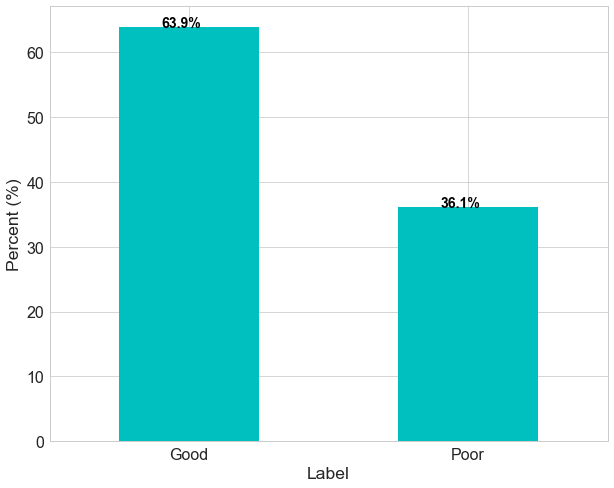

In [69]:
rev_score=(df_txt.label.value_counts(normalize=True).sort_index()*100)

# Define a function to plot bars with annotation; s: a series, rot: rotation of xtick labels; xlab: xlabels
def plot_bar(s,xlab,rot=0):
    ax=s.plot(kind='bar',rot=rot,color='c',figsize=(10,8))
    for i, v in enumerate(s):
        ax.text( i-0.1,v , str(round(v,1))+'%', color='black', fontweight='bold',fontsize=14)
    plt.xlabel(xlab)
    plt.ylabel('Percent (%)');
    
plot_bar(rev_score,'Label',0)

In [70]:
df_txt.drop('Reviewer_Score',axis=1).groupby('label').describe()

Hotel_City                        Neg_Rev_Lemmatized                   \
           count unique     top    freq              count  unique      top   
label                                                                         
Good      274515      6  London  134587             195286  152427  nothing   
Poor      154949      6  London   84868             148202  142182  nothing   

             Negative_Review                    Pos_Rev_Lemmatized          \
        freq           count  unique top   freq              count  unique   
label                                                                        
Good   15082          274515  166099      77112             268579  251096   
Poor     498          154949  146047       6431             136610  101312   

                      Positive_Review                    Rev_Lemmatized  \
            top  freq           count  unique top   freq          count   
label                                                                     
Good   location   918          274515  261096       5827         274515   
Poor   location  7260          154949  113815      18185         154949   

                                              Review_Month                     \
       unique                        top freq        count unique  top   freq   
label                                                                           
Good   274114     staff friendly helpful   18       274515     12  Aug  27163   
Poor   154844  room small location great    5       154949     12  Jul  15462   

      Reviewer_Nationality                                  Traveler_Type  \
                     count unique               top    freq         count   
label                                                                       
Good                274515    211   United Kingdom   136653        274515   
Poor                154949    206   United Kingdom    71781        154949   

                             Trip_Type                               
      unique     top    freq     count unique           top    freq  
label                                                                
Good       6  Couple  142209    267665      2  Leisure trip  232381  
Poor       6  Couple   70738    149850      2  Leisure trip  118401

In [71]:
# Lenghth of characters in a full-review
df_txt['Len_LemRev_char']=df_txt['Rev_Lemmatized'].apply(len)


Correlation: -0.12


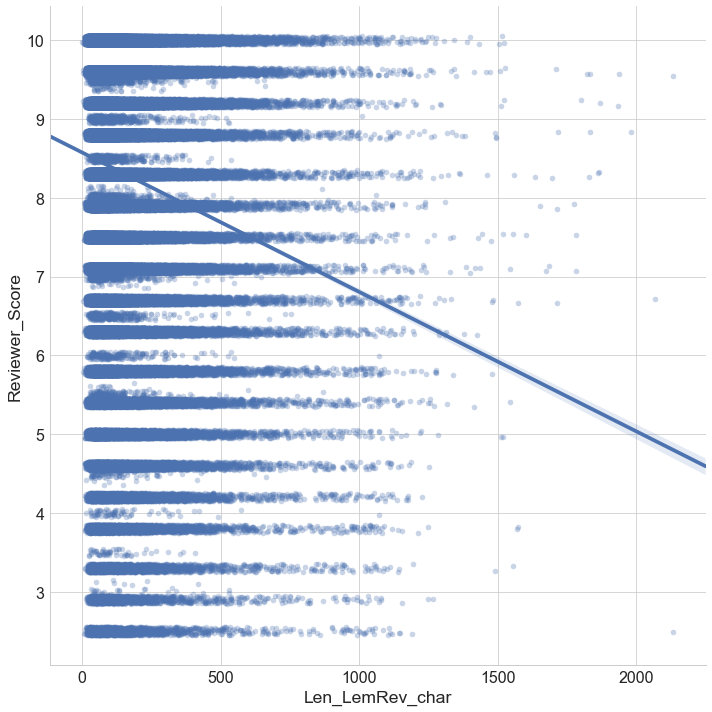

In [72]:
# How is the length of lemmatized clean reviews related with the reviewer score
sns.lmplot(y='Reviewer_Score',x='Len_LemRev_char',data=df_txt,y_jitter=0.05,size=10,scatter_kws={'alpha':0.3});
print('Correlation: %.2f'%(df_txt.Len_LemRev_char.corr(df_txt.Reviewer_Score)))

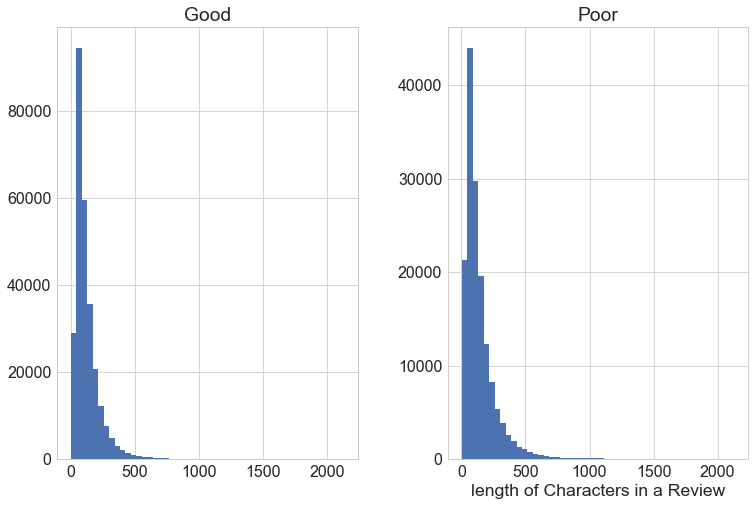

In [73]:
# Visualize the distribution of length of review strings by review label
df_txt.hist(column='Len_LemRev_char',by='label',bins=50,figsize=(12,8),rot=0,sharex=True)
plt.xlabel('length of Characters in a Review');

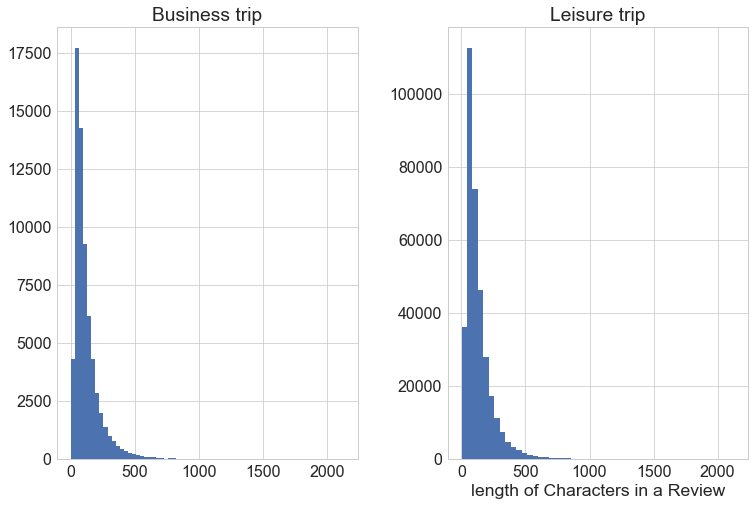

In [74]:
# Visualize the distribution of length of review strings by trip type
df_txt.hist(column='Len_LemRev_char',by='Trip_Type',bins=50,figsize=(12,8),rot=0,sharex=True);
plt.xlabel('length of Characters in a Review');

### t-test of the Character Length of Reviews
Is the average length of reviews significantly different for different trip categories ('business' trip and 'leisure trip')? We will investigate this issue by performing the t-test for means of two independent samples of reviews. The null hypothesis is that 2 independent samples (i.e., character length of reviews for business trip and that for leisure trip) have identical average length of characters. This is a two-sided test for 2 samples of different sizes.

In [75]:
np.round(df_txt.groupby('Trip_Type')['Len_LemRev_char'].size())#.mean()

Trip_Type
Business trip     66733
Leisure trip     350782
Name: Len_LemRev_char, dtype: int64

In [76]:

from scipy import stats

idx_leis=df_txt['Trip_Type']=='Leisure trip'
len_leis=df_txt[idx_leis]['Len_LemRev_char']
len_busi=df_txt[~idx_leis]['Len_LemRev_char']

t, p=stats.ttest_ind(len_leis, len_busi, equal_var = False)
#This test assumes that the populations have identical variances by default.
#equal_var=False: perform Welch’s t-test, which does not assume equal population variance 
print('t-statistic: %.2f' % (t),'\npvalue: %.2f' % (p))


t-statistic: 18.93 
pvalue: 0.00


In [77]:
np.round(df_txt.groupby('label')['Len_LemRev_char'].size())#.mean()

label
Good    274515
Poor    154949
Name: Len_LemRev_char, dtype: int64

In [78]:
idx_poor=df_txt['label']=='Poor'
idx_good=df_txt['label']=='Good'


len_poor=df_txt[idx_poor]['Len_LemRev_char']
len_good=df_txt[idx_good]['Len_LemRev_char']


t, p=stats.ttest_ind(len_poor, len_good, equal_var = False)
#This test assumes that the populations have identical variances by default.
#equal_var=False: perform Welch’s t-test, which does not assume equal population variance 
print('len_rev: poor v.s. good')
print('t-statistic: %.2f' % (t),'\npvalue: %.2f\n' % (p))

len_rev: poor v.s. good
t-statistic: 53.98 
pvalue: 0.00



Since the p-value is nearly zero for any two types of review categories, we reject the null hypothesis and conclude that the character length of reviews for different review categories are different.

## Build a Pipeline

In [79]:
# Use LabelBinarizer to convert labels into binary values
lab_bin=LabelBinarizer()
y=lab_bin.fit_transform(df_txt['label'])

In [80]:
#Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(df_txt['Rev_Lemmatized'], y,test_size=0.3,
    random_state=100)
y_train.shape, y_test.shape

((300624, 1), (128840, 1))

In [81]:
# Define a function to run the pipeline
def run_pipeline(steps,X_train,y_train,X_test,y_test):
    pipe=Pipeline(steps)
    pipe.fit(X_train,y_train)
    
    y_pred=pipe.predict(X_test)
    accu_train=pipe.score(X_train,y_train)
    accu_test=pipe.score(X_test,y_test)
    class_rep=classification_report(y_test,y_pred)
    conf_mtrix=confusion_matrix(y_test, y_pred) #,labels=['Poor','Good','Excellent']

    # Save the model
    #pickle.dump(pipe, open('pipe_model', 'wb'))
   
    print('Accuracy of training set: %.2f' %accu_train)
    print('Accuracy of test set: %.2f' %accu_test)
    print("\nConfusion Matrix:\n",conf_mtrix )
    print ('\nClassificatio Report:\n',class_rep)


    return pipe,accu_train, accu_test, conf_mtrix, class_rep

## Use bag-of-word Features for Prediction

### Dummy Classifier

we use the dummy classifer to get a baseline. In the dummy classifier, we use the 'most_frequent' strategy, hence the classifer always predict dominant class 'Good'.

In [82]:
# Use dummy classifier as the baseline 
from sklearn.dummy import DummyClassifier

df_txt['lab_cat']=y
X_train, X_test, y_train, y_test = train_test_split(df_txt['Rev_Lemmatized'], df_txt['lab_cat'],test_size=0.3,
    random_state=100)



bow_steps_dummy=[('vectorise',CountVectorizer(
                                        min_df=10,
                                        stop_words='english',
                                        token_pattern='[a-zA-Z]{3,}')),
         ('clf',DummyClassifier(strategy = 'most_frequent'))]

bow_pipe_dummy,bow_training_accuracy_dummy, bow_test_accuracy_dummy, bow_conf_mtrix_dummy, bow_class_report_dummy=run_pipeline(bow_steps_dummy,X_train,y_train,X_test,y_test)



Accuracy of training set: 0.64
Accuracy of test set: 0.64

Confusion Matrix:
 [[82592     0]
 [46248     0]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.64      1.00      0.78     82592
          1       0.00      0.00      0.00     46248

avg / total       0.41      0.64      0.50    128840



### NaiveBayes Classifier 
We use the naive bayes classifier to improve model performance.

In [83]:
bow_steps_NB=[('vectorise',CountVectorizer(
                                        min_df=10,
                                        stop_words='english',
                                        token_pattern='[a-zA-Z]{3,}')),
         ('clf',MultinomialNB())]

bow_pipe_NB,bow_training_accuracy_NB, bow_test_accuracy_NB, bow_conf_mtrix_NB, bow_class_report_NB=run_pipeline(bow_steps_NB,X_train,y_train,X_test,y_test)



Accuracy of training set: 0.78
Accuracy of test set: 0.78

Confusion Matrix:
 [[69757 12835]
 [15755 30493]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.82      0.84      0.83     82592
          1       0.70      0.66      0.68     46248

avg / total       0.78      0.78      0.78    128840



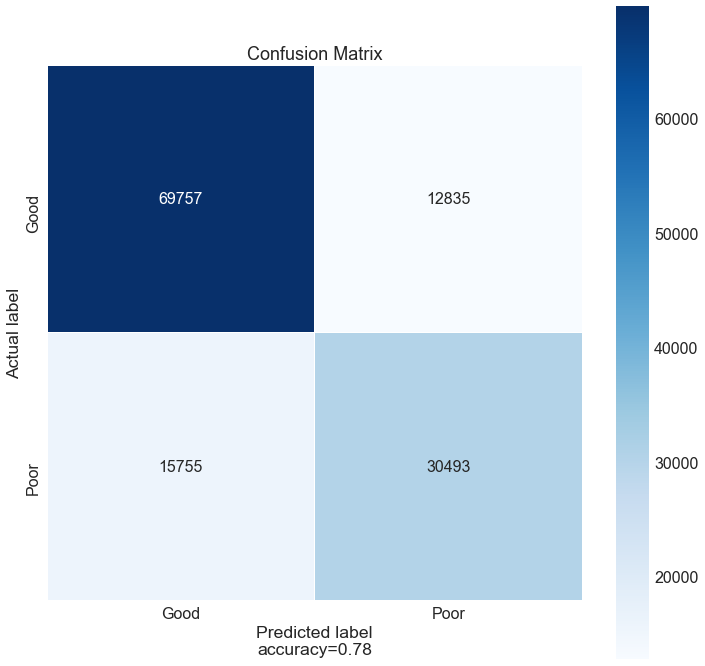

In [84]:
y_pred=bow_pipe_NB.predict(X_test)


plt.figure(figsize=(12,12))
ax=sns.heatmap(bow_conf_mtrix_NB, annot=True, fmt="d",linewidths=.5, square = True, cmap = 'Blues',annot_kws={'size':16});#fmt=".3f", 
plt.ylabel('Actual label');
#plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy_score(y_test,  y_pred), 1-accuracy_score(y_test,  y_pred)))
plt.xlabel('Predicted label\naccuracy={:0.2f}'.format(accuracy_score(y_test,  y_pred)))


plt.title('Confusion Matrix', size = 18)
ax.xaxis.set_ticklabels(['Good','Poor'])
ax.yaxis.set_ticklabels(['Good','Poor']);

#### Strongly Predictive Features
We build a dataset where each row contains just one word (identity matrix) and then uses the trained classifier to classify the one-word review. The probability for each row represents the probability that the review will be classified as 'poor'. We can see which words have the highest probability in ('poor') and which words have the lowest probability (low probability in being 'poor', hence high probability in being 'good' or 'excellent).



In [85]:
#Initialize the CountVectorizer with optimal hyperparameters
vectorizer=CountVectorizer(analyzer='word',       
                             min_df=10,
                             #ngram_range=(1, 2),
                             stop_words='english',             
                             #lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',  
                            #binary=True,
                       )
# Build the vocabulary by 'fit'
vectorizer.fit(df_txt['Rev_Lemmatized'])


#Make X and y
def make_xy(df_txt, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(df_txt.Rev_Lemmatized)
    X = X.tocsc()  
    y = df_txt.lab_cat.values
    return X, y
X, y = make_xy(df_txt,vectorizer)


# Set the train and test masks
itrain, _ = train_test_split(range(df_txt.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True

xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]



In [86]:
#Train the Naive Bayes model
clf = MultinomialNB(alpha=10).fit(xtrain, ytrain)
words = np.array(vectorizer.get_feature_names())

x = np.eye(xtest.shape[1])
# 'poor'
probs = clf.predict_log_proba(x)[:, 1]
ind = np.argsort(probs)[::-1]#reverse the order such that decending order

good_words =words[ind[:10]]   
bad_words =words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(Poor | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))
    
print("Bad words\t     P(Poor | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(np.exp(p)))





Good words	     P(Poor | word)
              filthy 0.90
           unhelpful 0.87
            impolite 0.87
             unclean 0.86
          disgusting 0.85
             disgust 0.85
               dirty 0.85
            arrogant 0.84
          unfriendly 0.83
               worst 0.83
Bad words	     P(Poor | word)
           amazingly 0.08
        immaculately 0.08
            hesitate 0.08
          immaculate 0.07
         beautifully 0.07
              highly 0.07
          spotlessly 0.06
          impeccable 0.06
                 gem 0.06
           memorable 0.06


## Use Tfidf-weighted Features for Prediction 
We already have a learned CountVectorizer, we will use it with a TfidfTransformer to generate the Tfidf-weighted features for prediction and we also include bigrams as features.

In [87]:
steps=[('vectorise', CountVectorizer(analyzer='word',       
                             min_df=10,
                             ngram_range=(1, 2),
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',  
                            #binary=False,
                       )),
       ('transform',TfidfTransformer()),
       ('clf',MultinomialNB())]
res_tfidf_NB_model=run_pipeline(steps,X_train,y_train,X_test,y_test) 


Accuracy of training set: 0.81
Accuracy of test set: 0.79

Confusion Matrix:
 [[72660  9932]
 [16874 29374]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.81      0.88      0.84     82592
          1       0.75      0.64      0.69     46248

avg / total       0.79      0.79      0.79    128840



### Feed Less TfidfVectorized Features to Classifier 
We select 5000 (rather than all 94711) features by implementing the most common feature selection technique for text mining, i.e., the chi-squared  ($\chi2$) method to see if the accuracy gets improved on test data set.

In [88]:
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1, 2),
                            stop_words='english',
                            token_pattern='[a-zA-Z]{3,}',
                           )

X, y = make_xy(df_txt,tfidf_vec)
selectf = SelectKBest(chi2, k=5000)
X_new=selectf.fit_transform(X, y)


itrain, _ = train_test_split(range(df_txt.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True



Xtrain=X_new[mask]
ytrain=y[mask]
Xtest=X_new[~mask]
ytest=y[~mask]

steps=[
       ('clf',MultinomialNB())
]

res_tfidf_NB_model2=run_pipeline(steps,Xtrain,ytrain,Xtest,ytest)            


Accuracy of training set: 0.79
Accuracy of test set: 0.79

Confusion Matrix:
 [[75606  6986]
 [20078 26170]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.79      0.92      0.85     82592
          1       0.79      0.57      0.66     46248

avg / total       0.79      0.79      0.78    128840



## Use sklearn LDA Document Topics for Prediction
**Build up the pipeline**

In [99]:
import warnings
warnings.filterwarnings('ignore')

import timeit
start_time = timeit.default_timer()


X_train, X_test, y_train, y_test=train_test_split(df_txt['Rev_Lemmatized'],y,test_size=0.3,random_state=100)
steps_skldan2=[('vectorise',CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
   )),
       ('LDA', LDA(n_components=2, random_state=100)),
       ('clf',MultinomialNB())]

res_skldan2=run_pipeline(steps_skldan2,X_train,y_train,X_test,y_test)
# # Save model using pickle
pickle.dump(res_skldan2, open('save/res_skldan2.sav', 'wb'))

elapsed = timeit.default_timer() - start_time 
print ('time', elapsed)

Accuracy of training set: 0.64
Accuracy of test set: 0.64

Confusion Matrix:
 [[82592     0]
 [46248     0]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.64      1.00      0.78     82592
          1       0.00      0.00      0.00     46248

avg / total       0.41      0.64      0.50    128840

time 741.1961834439862


In [89]:
import warnings
warnings.filterwarnings('ignore')

import timeit
start_time = timeit.default_timer()


X_train, X_test, y_train, y_test=train_test_split(df_txt['Rev_Lemmatized'],df_txt['lab_cat'],test_size=0.3,random_state=100)
steps_skldan5=[('vectorise',CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
   )),
       ('LDA', LDA(n_components=5, random_state=100)),
       ('clf',MultinomialNB())]

res_skldan5=run_pipeline(steps_skldan5,X_train,y_train,X_test,y_test)
# # Save model using pickle
pickle.dump(res_skldan5, open('save/res_skldan5.sav', 'wb'))

elapsed = timeit.default_timer() - start_time 
print ('time', elapsed)

Accuracy of training set: 0.65
Accuracy of test set: 0.65

Confusion Matrix:
 [[81782   810]
 [44408  1840]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.65      0.99      0.78     82592
          1       0.69      0.04      0.08     46248

avg / total       0.66      0.65      0.53    128840

time 852.3467739010011


In [91]:
import warnings
warnings.filterwarnings('ignore')

import timeit
start_time = timeit.default_timer()


X_train, X_test, y_train, y_test=train_test_split(df_txt['Rev_Lemmatized'],df_txt['lab_cat'],test_size=0.3,random_state=100)
steps_skldan10=[('vectorise',CountVectorizer(analyzer='word',       
                             min_df=10,                       
                             stop_words='english',             
                             lowercase=True,                  
                             token_pattern='[a-zA-Z]{3,}',    # num chars > 3 
   )),
       ('LDA', LDA(n_components=10, random_state=100)),
       ('clf',MultinomialNB())]

res_skldan10=run_pipeline(steps_skldan10,X_train,y_train,X_test,y_test)
# # Save model using pickle
pickle.dump(res_skldan10, open('save/res_skldan10.sav', 'wb'))

elapsed = timeit.default_timer() - start_time 
print ('time', elapsed)

Accuracy of training set: 0.64
Accuracy of test set: 0.64

Confusion Matrix:
 [[82572    20]
 [46150    98]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.64      1.00      0.78     82592
          1       0.83      0.00      0.00     46248

avg / total       0.71      0.64      0.50    128840

time 948.6639230680012


## Use Gensim LDA Document Topics for Prediction

In [92]:
def gensim_lda_feature(doc,dictionary,corpus,num_topics,ldamodel):
    """extract document-topic matrix from gensim lda and convert it into a form ready to be used for prediction """
    
    # Create document-topic-matrix for new documents
    doc_tokenized=process_text(doc)
    doc_bow=[dictionary.doc2bow(d) for d in doc_tokenized]
    dtm=ldamodel.get_document_topics(doc_bow)

        # Convert dtm to numpy array
    dtm_csr = gensim.matutils.corpus2csc(dtm)
    dtm_numpy = dtm_csr.T.toarray()

    return dtm_numpy
    

# a FunctionTransformer turns a python function into an object that a scikit-learn pipeline can understand
gensim_lda_extractFeature=FunctionTransformer(lambda x: gensim_lda_feature(x,dictionary,corpus,ntopics,lda),validate=False)

X_rev=df_txt['Rev_Lemmatized']
y=df_txt['lab_cat']


# Split data into training and test set
itrain, _ = train_test_split(range(df_txt.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True

X_train=X_rev[mask]
y_train=y[mask]

X_test=X_rev[~mask]
y_test=y[~mask]

In [93]:
import timeit
start_time = timeit.default_timer()


ntopics=5
#build_lda(X_train,ntopics,passes=15);
    
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
ldan5 = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
#gensim_lda_feature(X_train,dictionary,corpus,ntopics,ldan5)

# a FunctionTransformer turns a python function into an object that a scikit-learn pipeline can understand
gensim_lda_extractFeature=FunctionTransformer(lambda x: gensim_lda_feature(
    x,dictionary,corpus,ntopics,ldan5),validate=False)
steps_gsmldan5=[('gensimLDA',gensim_lda_extractFeature),
       ('clf',MultinomialNB())]
res_lda_gsm_n5=run_pipeline(steps_gsmldan5,X_train,y_train,X_test,y_test)

elapsed = timeit.default_timer() - start_time 
print ('time', elapsed)

Accuracy of training set: 0.65
Accuracy of test set: 0.65

Confusion Matrix:
 [[81921   671]
 [43858  2390]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.65      0.99      0.79     82592
          1       0.78      0.05      0.10     46248

avg / total       0.70      0.65      0.54    128840

time 780.6587556020022


In [94]:
import timeit
start_time = timeit.default_timer()


ntopics=10
ldan10 = gensim.models.ldamodel.LdaModel.load('model{0}.gensim'.format(ntopics))
#gensim_lda_feature(X_train,dictionary,corpus,ntopics,ldan10)


# a FunctionTransformer turns a python function into an object that a scikit-learn pipeline can understand
gensim_lda_extractFeature=FunctionTransformer(lambda x: gensim_lda_feature(
    x,dictionary,corpus,ntopics,ldan10),validate=False)
steps_gsmldan10=[('gensimLDA',gensim_lda_extractFeature),
       ('clf',MultinomialNB())]
res_lda_gsm_n10=run_pipeline(steps_gsmldan10,X_train,y_train,X_test,y_test)

elapsed = timeit.default_timer() - start_time 
print(elapsed)#852.7997626879951

Accuracy of training set: 0.65
Accuracy of test set: 0.65

Confusion Matrix:
 [[82019   573]
 [44721  1527]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.65      0.99      0.78     82592
          1       0.73      0.03      0.06     46248

avg / total       0.68      0.65      0.53    128840



##  Compare Model Performance
We plot the ROC curve for evaluation of model performances. AUC is the size of area under the plotted curve. In ROC (Receiver operating characteristic) curve, true positive rates are plotted against false positive rates. The closer AUC of a model is getting to 1, the better the model is. It means, a model with higher AUC is preferred over those with lower AUC.

In [161]:
import timeit
start_time = timeit.default_timer()



models=[bow_pipe_dummy,
        bow_pipe_NB,
        res_tfidf_NB_model[0],
        res_tfidf_NB_model2[0],
        res_skldan2[0],
        res_skldan5[0],
        res_skldan10[0],
        res_lda_gsm_n5[0],
        res_lda_gsm_n10[0]        
           ]

m_names=['bow_dummy',
        'bow_NB',
        'tfidf_NB',
        'tfidf_NBchi',
        'sklearn_ldan2',
        'sklearn_ldan5',
        'sklearn_ldan10',
        'gsm_ldan5',
        'gsm_ldan10',
        ]
Probs = []
FPRs = []
TPRs = []
ROC_AUCs =[]

Recs=[]
Precs=[]
Aps=[]
for k in range(0,len(models)):
    name = m_names[k] 
    if k==3:
        prob=models[k].predict_proba(Xtest)
        y_pred = prob[:,1]
        fpr, tpr, threshold = roc_curve(ytest, y_pred, pos_label=1)
        prec, rec, threshold = precision_recall_curve(ytest, y_pred)
        ap=average_precision_score(ytest, y_pred)
    else:
        prob =models[k].predict_proba(X_test)
        y_pred = prob[:,1]
        fpr, tpr, threshold = roc_curve(y_test, y_pred, pos_label=1)
        prec, rec, threshold = precision_recall_curve(y_test, y_pred)
        ap=average_precision_score(y_test, y_pred)

    roc_auc = auc(fpr, tpr)
    Probs.append(prob)
    FPRs.append(fpr)
    TPRs.append(tpr)
    ROC_AUCs.append(roc_auc)
    
    
    Recs.append(rec)
    Precs.append(prec)
    Aps.append(ap)
    
elapsed = timeit.default_timer() - start_time 
print ('time', elapsed)


time 340.35308881799574


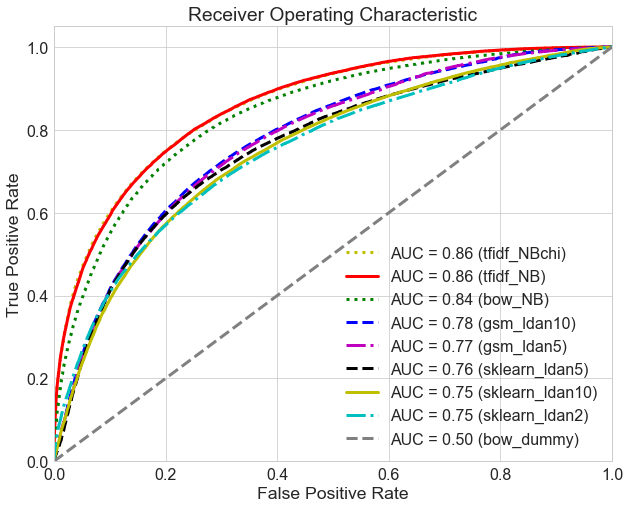

In [137]:
rcParams['figure.figsize'] = 10, 8


## plot ROC curve
plt.title('Receiver Operating Characteristic')

plt.plot(FPRs[3], TPRs[3], 'y', linestyle=':',label='AUC = %0.2f (%s)'% (ROC_AUCs[3],m_names[3]),linewidth=3)
plt.plot(FPRs[2], TPRs[2], 'r', label='AUC = %0.2f (%s)'% (ROC_AUCs[2],m_names[2]),linewidth=3)
plt.plot(FPRs[1], TPRs[1], 'g',linestyle=':', label='AUC = %0.2f (%s)'% (ROC_AUCs[1],m_names[1]),linewidth=3)
plt.plot(FPRs[8], TPRs[8], 'b', linestyle='--',label='AUC = %0.2f (%s)'% (ROC_AUCs[8],m_names[8]),linewidth=3)
plt.plot(FPRs[7], TPRs[7], 'm',linestyle='-.', label='AUC = %0.2f (%s)'% (ROC_AUCs[7],m_names[7]),linewidth=3)
plt.plot(FPRs[5], TPRs[5], 'k',linestyle='--', label='AUC = %0.2f (%s)'% (ROC_AUCs[5],m_names[5]),linewidth=3)
plt.plot(FPRs[6], TPRs[6], 'y', label='AUC = %0.2f (%s)'% (ROC_AUCs[6],m_names[6]),linewidth=3)
plt.plot(FPRs[4], TPRs[4], 'c',linestyle='-.', label='AUC = %0.2f (%s)'% (ROC_AUCs[4],m_names[4]),linewidth=3)
plt.plot(FPRs[0], TPRs[0], 'gray', linestyle='--',label='AUC = %0.2f (%s)'% (ROC_AUCs[0],m_names[0]),linewidth=3)



#plt.plot([0,1],[0,1],color='gray', lw=1, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right");



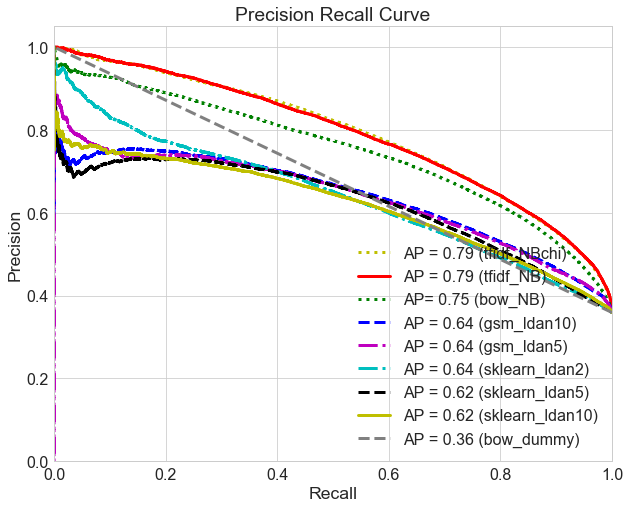

In [162]:
rcParams['figure.figsize'] = 10, 8


## plot PR curve
plt.title('Precision Recall Curve')
plt.plot(Recs[3], Precs[3], 'y', linestyle=':',label='AP = %0.2f (%s)'% (Aps[3],m_names[3]),linewidth=3)
plt.plot(Recs[2], Precs[2], 'r', label='AP = %0.2f (%s)'% (Aps[2],m_names[2]),linewidth=3)
plt.plot(Recs[1], Precs[1], 'g',linestyle=':', label='AP= %0.2f (%s)'% (Aps[1],m_names[1]),linewidth=3)
plt.plot(Recs[8], Precs[8], 'b', linestyle='--',label='AP = %0.2f (%s)'% (Aps[8],m_names[8]),linewidth=3)
plt.plot(Recs[7], Precs[7], 'm',linestyle='-.', label='AP = %0.2f (%s)'% (Aps[7],m_names[7]),linewidth=3)
plt.plot(Recs[4], Precs[4], 'c',linestyle='-.', label='AP = %0.2f (%s)'% (Aps[4],m_names[4]),linewidth=3)
plt.plot(Recs[5], Precs[5], 'k',linestyle='--', label='AP = %0.2f (%s)'% (Aps[5],m_names[5]),linewidth=3)
plt.plot(Recs[6], Precs[6], 'y', label='AP = %0.2f (%s)'% (Aps[6],m_names[6]),linewidth=3)
plt.plot(Recs[0], Precs[0], 'gray', linestyle='--',label='AP = %0.2f (%s)'% (Aps[0],m_names[0]),linewidth=3)





#plt.plot([0,1],[1,0],color='gray', lw=3, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right");






### Pick Classifiers
As indicated in the ROC curve above, concerning texts, the Tf-idf vectorized features as inputs give the best model performance. We will take Tf-idf vectorized features to represent review texts. We will train the model using different classifiers aiming to improve model performance furthermore.

In [139]:
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1, 2),
                            stop_words='english',
                            token_pattern='[a-zA-Z]{3,}',
                           )

X, y = make_xy(df_txt,tfidf_vec)
#X_new = SelectKBest(chi2, k=10).fit_transform(X, y)
X_new = SelectKBest(chi2, k=5000).fit_transform(X, y)


itrain, _ = train_test_split(range(df_txt.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True



Xtrain=X_new[mask]
ytrain=y[mask]
Xtest=X_new[~mask]
ytest=y[~mask]


In [140]:
X.shape, X_new.shape

((429464, 94711), (429464, 5000))

####  Conduct Cross Validation to Estimate Accuracy
We use 5-fold cross validation to estimate accuracy.

In [9]:
import timeit
start_time = timeit.default_timer()

classifers=[MultinomialNB(),
            LogisticRegression(),
            #SGDClassifier(loss='log'),
            RandomForestClassifier()
           ]
c_names=['NB','LR','RF']



results = []
for i in range(len(classifers)):
    steps=[('clf',classifers[i])]
    print("---------------------------------------------------------------") 
    print("%s:"%c_names[i])

    rp=run_pipeline(steps,Xtrain,ytrain,Xtest,ytest)
    model=rp[0]
    kf = KFold(Xtrain.shape[0], n_folds=5, random_state=100) 
    cv_results = cross_val_score(model, 
                                 Xtrain, 
                                 ytrain, 
                                 cv=kf, 
                                 scoring='accuracy') 
    results.append(cv_results)
    #dftParams = model.named_steps.items()
    #print("Default model parameters are: \n{}".format(dftParams) )
    print("%s: %.2f (%.3f)" % (' mean training accuracy (std)', cv_results.mean(), cv_results.std()))
elapsed = timeit.default_timer() - start_time
print ('time:', elapsed)

---------------------------------------------------------------
NB:
Accuracy of training set: 0.79
Accuracy of test set: 0.79

Confusion Matrix:
 [[75606  6986]
 [20078 26170]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.79      0.92      0.85     82592
          1       0.79      0.57      0.66     46248

avg / total       0.79      0.79      0.78    128840

 mean training accuracy (std): 0.79 (0.004)
---------------------------------------------------------------
LR:
Accuracy of training set: 0.81
Accuracy of test set: 0.80

Confusion Matrix:
 [[72664  9928]
 [15879 30369]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.82      0.88      0.85     82592
          1       0.75      0.66      0.70     46248

avg / total       0.80      0.80      0.80    128840

 mean training accuracy (std): 0.80 (0.004)
---------------------------------------------------------------
RF:
Accuracy of 

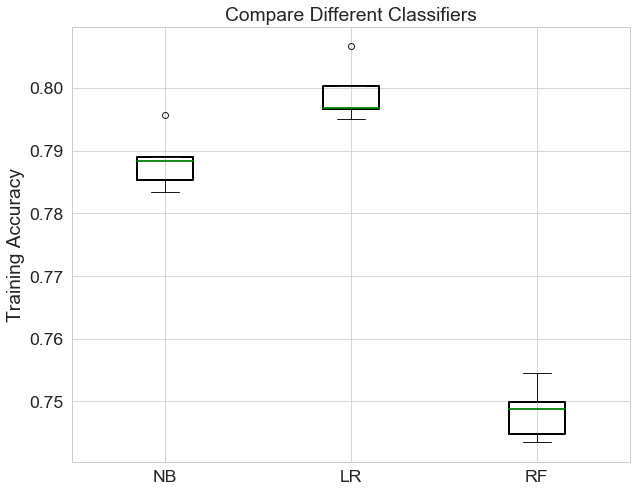

In [12]:
boxprops = dict(linestyle='-', linewidth=2, color='black')
medianprops = dict(linestyle='-', linewidth=1.8, color='green')

plt.boxplot(results,boxprops=boxprops,medianprops=medianprops) 
#ax.set_xticklabels(names) 
plt.xticks([1,2,3],c_names)
plt.ylabel("Training Accuracy")
plt.title('Compare Different Classifiers');

According to the cross validation result, the logistic regression algorithm performs best on the training set.

#### Plot ROC-AUC Curve on Test Set

In [13]:
Probs_c = []
FPRs_c  = []
TPRs_c  = []
ROC_AUCs_c =[]

Recs_c =[]
Precs_c =[]
Aps_c =[]


for i in range(0,len(classifers)):
    steps=[('clf',classifers[i])]
    name=c_names[i]
    print('-----------------------')
    print('Classifier: ', name)
    m=run_pipeline(steps,Xtrain,ytrain,Xtest,ytest)            
    
    prob=m[0].predict_proba(Xtest)
    y_pred=prob[:,1]
    fpr,tpr,threshold=roc_curve(ytest,y_pred)
    roc_auc=auc(fpr,tpr)


    prec, rec, threshold = precision_recall_curve(ytest, y_pred)
    ap=average_precision_score(ytest, y_pred)
    
    Probs_c.append(prob)
    FPRs_c.append(fpr)
    TPRs_c.append(tpr)
    ROC_AUCs_c.append(roc_auc)
    
    Recs_c.append(rec)
    Precs_c.append(prec)
    Aps_c.append(ap)



-----------------------
Classifier:  NB
Accuracy of training set: 0.79
Accuracy of test set: 0.79

Confusion Matrix:
 [[75606  6986]
 [20078 26170]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.79      0.92      0.85     82592
          1       0.79      0.57      0.66     46248

avg / total       0.79      0.79      0.78    128840

-----------------------
Classifier:  LR
Accuracy of training set: 0.81
Accuracy of test set: 0.80

Confusion Matrix:
 [[72664  9928]
 [15879 30369]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.82      0.88      0.85     82592
          1       0.75      0.66      0.70     46248

avg / total       0.80      0.80      0.80    128840

-----------------------
Classifier:  RF
Accuracy of training set: 0.98
Accuracy of test set: 0.75

Confusion Matrix:
 [[73752  8840]
 [23296 22952]]

Classificatio Report:
              precision    recall  f1-score   suppor

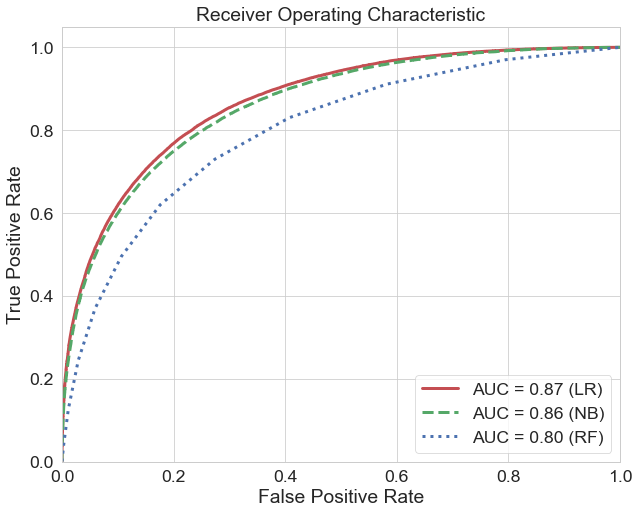

In [14]:
## plot ROC curve
plt.title('Receiver Operating Characteristic')

plt.plot(FPRs_c[1], TPRs_c[1], 'r', label='AUC = %0.2f (%s)'% (ROC_AUCs_c[1],c_names[1]),linewidth=3)
plt.plot(FPRs_c[0], TPRs_c[0], 'g', linestyle='--',label='AUC = %0.2f (%s)'% (ROC_AUCs_c[0],c_names[0]),linewidth=3)
plt.plot(FPRs_c[2], TPRs_c[2], 'b',linestyle=':', label='AUC = %0.2f (%s)'% (ROC_AUCs_c[2],c_names[2]),linewidth=3)
#plt.plot(FPRs_c[3], TPRs_c[3], 'g', label='AUC = %0.2f (%s)'% (ROC_AUCs_c[3],c_names[3]),linewidth=3)

#plt.plot([0,1],[0,1],color='gray', lw=1, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right");


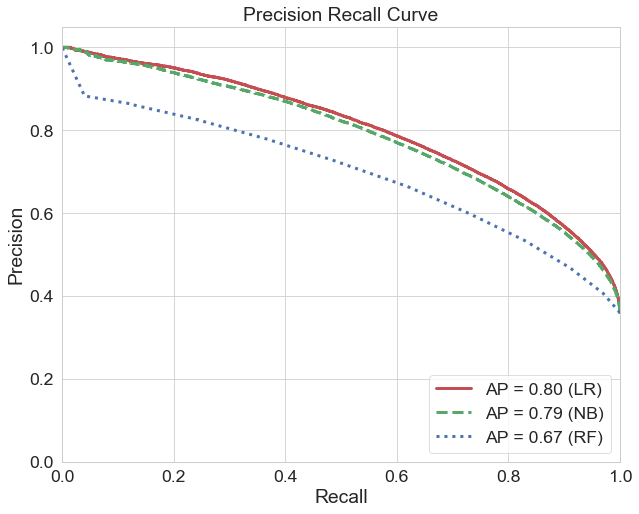

In [15]:
# Plot PR curve
plt.title('Precision Recall Curve')

plt.plot(Recs_c[1], Precs_c[1], 'r', label='AP = %0.2f (%s)'% (Aps_c[1],c_names[1]),linewidth=3)
plt.plot(Recs_c[0], Precs_c[0], 'g', linestyle='--',label='AP = %0.2f (%s)'% (Aps_c[0],c_names[0]),linewidth=3)
plt.plot(Recs_c[2], Precs_c[2], 'b',linestyle=':', label='AP = %0.2f (%s)'% (Aps_c[2],c_names[2]),linewidth=3)
#plt.plot(Recs_c[3], Precs_c[3], 'g', label='AP = %0.2f (%s)'% (Aps_c[3],c_names[3]),linewidth=3)


#plt.plot([0,1],[1,0],color='gray', lw=3, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right");

### Grid Search Hyperparameters
We define a customized gridsearch function and specify our search parameters for the LogisticRegression model. 

In [167]:
#bow_pipe.named_steps.keys()

# Define a function for GridSearch
def my_grid_search(model,search_params,X_train,y_train,X_test,y_test,nfolds=5,scoring='accuracy'):
    gsmodel= GridSearchCV(model, param_grid=search_params,scoring=scoring,cv=nfolds)
    gsmodel=gsmodel.fit(X_train,y_train)
    
    # Save the best model
    # best_model=gsmodel.best_estimator_
    # pickle.dump(best_model,open('bestmodel','wb'))
            
    y_pred=gsmodel.predict(X_test)
    print('Best paras:\n')
    pprint(gsmodel.best_params_)
    print('\nBest score: %.2f' % gsmodel.best_score_)
    print('\nClassification report: \n',classification_report(y_test,y_pred))
    
    return gsmodel,gsmodel.best_params_,gsmodel.best_score_,classification_report(y_test,y_pred)


steps=[('clf',LogisticRegression())]
lg_pl=run_pipeline(steps,Xtrain,ytrain,Xtest,ytest)            
lg_pl[0].named_steps.keys() 

Accuracy of training set: 0.81
Accuracy of test set: 0.80

Confusion Matrix:
 [[72664  9928]
 [15879 30369]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.82      0.88      0.85     82592
          1       0.75      0.66      0.70     46248

avg / total       0.80      0.80      0.80    128840



dict_keys(['clf'])

In [168]:
import timeit
start_time = timeit.default_timer()


nfolds=5
search_params = dict(
                  clf__C=[0.1,1,10,20],
                  clf__penalty=['l1','l2'],
                 )

lgGS, _,_, lgGS_class_report=my_grid_search(lg_pl[0],search_params,Xtrain,ytrain,Xtest,ytest,nfolds,scoring='f1')

elapsed = timeit.default_timer() - start_time #11:37-11:57 #1183.102044557003 seconds
print('time',elapsed)


Best paras:

{'clf__C': 10, 'clf__penalty': 'l2'}

Best score: 0.70

Classification report: 
              precision    recall  f1-score   support

          0       0.82      0.88      0.85     82592
          1       0.75      0.66      0.70     46248

avg / total       0.80      0.80      0.80    128840

time 166.27425103499263


The default 'penalty' is 'l2'. The grid search procedure doesn't improve model performance further.

### Save the model

In [169]:
import dill as pickle
filename = 'lg_tfidf_gs_text.sav'
pickle.dump(lgGS,open(filename, 'wb'))

lgGS=pickle.load(open(filename, 'rb'))


lgGS.predict_proba(Xtest)

array([[0.1393631 , 0.8606369 ],
       [0.44139131, 0.55860869],
       [0.10289219, 0.89710781],
       ...,
       [0.3279149 , 0.6720851 ],
       [0.5404337 , 0.4595663 ],
       [0.83145101, 0.16854899]])

### What are the most useful word features?

In [10]:
tfidf_vec = TfidfVectorizer(min_df=10,
                            ngram_range=(1, 2),
                            stop_words='english',
                            token_pattern='[a-zA-Z]{3,}',
                           )

X, y = make_xy(df_txt,tfidf_vec)
selectf=SelectKBest(chi2, k=5000)
X_new = selectf.fit_transform(X, y)


itrain, _ = train_test_split(range(df_txt.shape[0]), test_size=0.3,random_state=100)
mask = np.zeros(df_txt.shape[0], dtype=np.bool)
mask[itrain] = True



Xtrain=X_new[mask]
ytrain=y[mask]
Xtest=X_new[~mask]
ytest=y[~mask]


steps=[
       ('clf',LogisticRegression())
]


res_tfidf_LR_model2=run_pipeline(steps,Xtrain,ytrain,Xtest,ytest)            




Accuracy of training set: 0.81
Accuracy of test set: 0.80

Confusion Matrix:
 [[72664  9928]
 [15879 30369]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.82      0.88      0.85     82592
          1       0.75      0.66      0.70     46248

avg / total       0.80      0.80      0.80    128840



In [11]:
fnames=tfidf_vec.get_feature_names()
words=np.asarray([fnames[i] for i in selectf.get_support(indices=True)])
model=res_tfidf_LR_model2[0].named_steps['clf']
cof=model.coef_[0].T

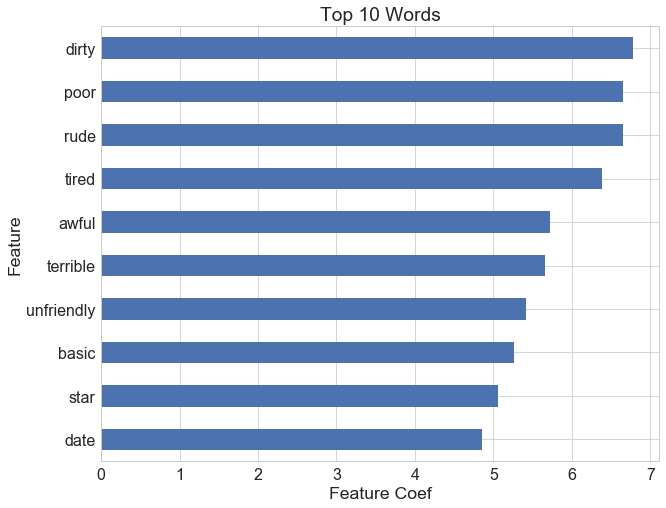

In [12]:
idx=np.argsort(cof)[::-1]
best10words=pd.DataFrame({'coef':cof[idx[:10]]},index=words[idx[:10]]).sort_values('coef')
best10words.plot(kind='barh',rot=0,legend=False)
plt.xlabel('Feature Coef')
plt.ylabel('Feature')
plt.title('Top 10 Words');



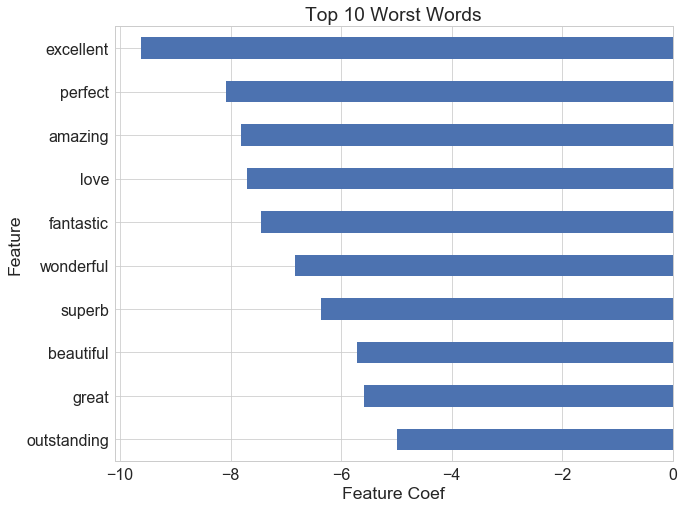

In [13]:
worst10words=pd.DataFrame({'coef':cof[idx[-10:]]},index=words[idx[-10:]])
worst10words.plot(kind='barh',rot=0,legend=False)
plt.xlabel('Feature Coef')
plt.ylabel('Feature')
plt.title('Top 10 Worst Words');

## Enrich Predictors with Categorical and Numerical Features
According to our exploratory data analysis, the reviewer score is corrected with features like 'Trip_Type' and 'Num_Nights' etc. We will include those categorical and numerical features in this section to show whether it will improve the model performance. Since it's more important to know whether a hotel is reviewed as poor/not poor than to know that a hotel is reviewed as good/excellent. Let's categorize the reviews into two types by the 0.33 quantile of reviewers' score.


We extract categorical columns and numerical columns and fill missing values in categorical columns with 'None'. We impute missing values in numerical features by its median. Then split the data into training and test set.

In [170]:
# Load data
#df_txt=pd.read_csv('data/htl_rev_lem_added.csv')
#df_txt['Rev_Lemmatized']=df_txt['Neg_Rev_Lemmatized'].fillna('')+' '+df_txt['Pos_Rev_Lemmatized'].fillna('')
data=pd.read_csv('data/htl_clean.csv')

col_num=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts',
          'Review_Total_Negative_Word_Counts','Num_Nights']

# Extract numerical columns
cthresh=10
idx=(data['Review_Total_Positive_Word_Counts']+data['Review_Total_Negative_Word_Counts'])<cthresh
df_num=data[~idx][col_num].reset_index(drop=True)


# Combine features
df_ml=pd.concat([df_txt,df_num],axis=1)



In [171]:
df_ml.head()

,Review_Month,Hotel_City,Reviewer_Nationality,Trip_Type,Traveler_Type,Negative_Review,Positive_Review,Reviewer_Score,Neg_Rev_Lemmatized,Pos_Rev_Lemmatized,Rev_Lemmatized,label,Len_LemRev_char,lab_cat,Total_Number_of_Reviews_Reviewer_Has_Given,Review_Total_Positive_Word_Counts,Review_Total_Negative_Word_Counts,Num_Nights
0,Aug,Amsterdam,Russia,Leisure trip,Couple,I am so angry that i made this post available...,Only the park outside of the hotel was beauti...,2.9,angry make post available possible site use pl...,park beautiful,angry make post available possible site use pl...,Poor,955,1,7,11,397,6.0
1,Aug,Amsterdam,Ireland,Leisure trip,Couple,,No real complaints the hotel was great great ...,7.5,NaN,real complaint great great location surroundin...,real complaint great great location surroundi...,Poor,421,1,7,105,0,4.0
2,Jul,Amsterdam,Australia,Leisure trip,Family with young children,Rooms are nice but for elderly a bit difficul...,Location was good and staff were ok It is cut...,7.1,room nice elderly bit difficult room story nar...,location good staff cute breakfast range nice ...,room nice elderly bit difficult room story nar...,Poor,171,1,9,21,42,3.0
3,Jul,Amsterdam,United Kingdom,Leisure trip,Solo traveler,My room was dirty and I was afraid to walk ba...,Great location in nice surroundings the bar a...,3.8,room dirty afraid walk barefoot floor look cle...,great location nice surrounding bar restaurant...,room dirty afraid walk barefoot floor look cle...,Poor,744,1,1,26,210,3.0
4,Jul,Amsterdam,New Zealand,Leisure trip,Couple,You When I booked with your company on line y...,Amazing location and building Romantic setting,6.7,book company line show picture room think get ...,amazing location build romantic setting,book company line show picture room think get ...,Poor,398,1,3,8,140,2.0


In [172]:
df_ml.isnull().sum()

Review_Month                                      0
Hotel_City                                        0
Reviewer_Nationality                              0
Trip_Type                                     11949
Traveler_Type                                     0
Negative_Review                                   0
Positive_Review                                   0
Reviewer_Score                                    0
Neg_Rev_Lemmatized                            85976
Pos_Rev_Lemmatized                            24275
Rev_Lemmatized                                    0
label                                             0
Len_LemRev_char                                   0
lab_cat                                           0
Total_Number_of_Reviews_Reviewer_Has_Given        0
Review_Total_Positive_Word_Counts                 0
Review_Total_Negative_Word_Counts                 0
Num_Nights                                      159
dtype: int64

In [173]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429464 entries, 0 to 429463
Data columns (total 18 columns):
Review_Month                                  429464 non-null object
Hotel_City                                    429464 non-null object
Reviewer_Nationality                          429464 non-null object
Trip_Type                                     417515 non-null object
Traveler_Type                                 429464 non-null object
Negative_Review                               429464 non-null object
Positive_Review                               429464 non-null object
Reviewer_Score                                429464 non-null float64
Neg_Rev_Lemmatized                            343488 non-null object
Pos_Rev_Lemmatized                            405189 non-null object
Rev_Lemmatized                                429464 non-null object
label                                         429464 non-null object
Len_LemRev_char                               429464 non-nul

In [188]:
col_categories=['Review_Month', 'Hotel_City', 'Trip_Type','Traveler_Type']
df_ml.Trip_Type.fillna('None',inplace=True)

col_num=['Total_Number_of_Reviews_Reviewer_Has_Given','Review_Total_Positive_Word_Counts',
          'Review_Total_Negative_Word_Counts','Len_LemRev_char']

X=df_ml[col_categories+col_num+['Rev_Lemmatized']]
y=lab_bin.fit_transform(df_ml['label'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,test_size=0.3,random_state=100)

Use the FunctionTransformer to create an object out of a Python function that help select subsets of data in a way that plays nicely with pipelines.

In [189]:
get_text_data=FunctionTransformer(lambda x: x['Rev_Lemmatized'],validate=False)
get_num_data=FunctionTransformer(lambda x: x[col_num],validate=False)
get_cat_data=FunctionTransformer(lambda x: pd.get_dummies(x[col_categories],drop_first=True),validate=False)

# Build text pipeline
text_pipeline=Pipeline([('selector', get_text_data ),
                        ('vectorise',TfidfVectorizer(
                                        min_df=10,
                                        ngram_range=(1,2),
                                        stop_words='english',
                                        token_pattern='[a-zA-Z]{3,}')),
                       ('dim_red',SelectKBest(chi2,k=5000))
                       ])
# Build cat pipeline
cat_pipeline=Pipeline([('selector',get_cat_data),
                        #('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),#doesn't work with sparse matrix                      
                      ])

# Build num pipeline
num_pipeline=Pipeline([('selector',get_num_data),
                        ('imputer',Imputer(strategy='median')),
                       ('interact',PolynomialFeatures(degree=2,interaction_only=True,include_bias=False)),               
                       ('scaler',MinMaxScaler()),
                      ])

# Union numeric and text features
union=FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])




In [190]:
steps_LR=[
    ('union',FeatureUnion([('cat',cat_pipeline),('num',num_pipeline),('text',text_pipeline)])),
    ('clf',LogisticRegression(C=10.,penalty='l2'))
    ]
res_LR=run_pipeline(steps_LR,X_train,y_train,X_test,y_test)


Accuracy of training set: 0.82
Accuracy of test set: 0.81

Confusion Matrix:
 [[72598  9994]
 [14893 31355]]

Classificatio Report:
              precision    recall  f1-score   support

          0       0.83      0.88      0.85     82592
          1       0.76      0.68      0.72     46248

avg / total       0.80      0.81      0.80    128840



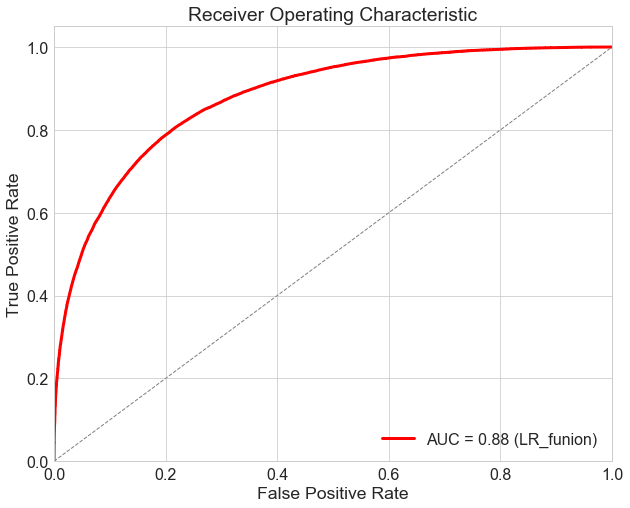

In [191]:
prob=res_LR[0].predict_proba(X_test)
y_pred=prob[:,1]
fpr,tpr,threshold=roc_curve(y_test,y_pred)
    
roc_auc=auc(fpr,tpr)


## plot ROC curve
plt.title('Receiver Operating Characteristic')

plt.plot(fpr, tpr, 'r', label='AUC = %0.2f (%s)'% (roc_auc,'LR_funion'),linewidth=3)

plt.plot([0,1],[0,1],color='gray', lw=1, linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc="lower right");

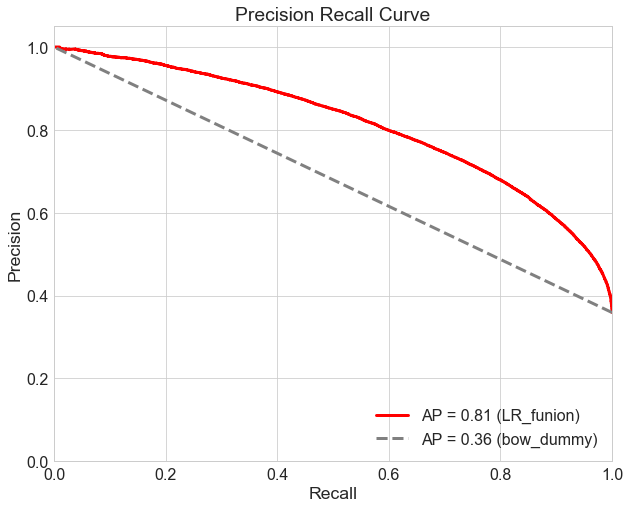

In [197]:
prec, rec, threshold = precision_recall_curve(y_test, y_pred)
ap=average_precision_score(y_test, y_pred)

plt.title('Precision Recall Curve')
plt.plot(rec, prec, 'r', label='AP = %0.2f (%s)'% (ap,'LR_funion'),linewidth=3)
plt.plot(Recs[0], Precs[0], 'gray', linestyle='--',label='AP = %0.2f (%s)'% (Aps[0],m_names[0]),linewidth=3)


plt.xlim([0,1])
plt.ylim([0,1.05])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.legend(loc="lower right");



### Save the model

In [196]:
import dill as pickle
filename = 'lg_tfidf_funion.sav'
pickle.dump(res_LR[0],open(filename, 'wb'))

best_model=pickle.load(open(filename, 'rb'))


best_model.predict_proba(X_test)

array([[0.64127724, 0.35872276],
       [0.6447455 , 0.3552545 ],
       [0.37183637, 0.62816363],
       ...,
       [0.9862267 , 0.0137733 ],
       [0.06618352, 0.93381648],
       [0.13953932, 0.86046068]])